# EdgeR - Non-rarefied & abundance-filtered data 

In [1]:
library(edgeR)
library(phyloseq)
library(tidyverse)
library(metagMisc)
library(microViz)
library(conflicted)
library(pheatmap)
library(viridis)
library(gridExtra)
library(ggplot2)
library(pheatmap)

Loading required package: limma

── Attaching packages ──────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.0     ✔ stringr 1.5.1
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ─────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘metagMisc’


The following object is masked from ‘package:purrr’:

    some



microViz version 0.9.6 - Copyright (C) 2022 David Barnett
* Website: https://david-barnett.github.io/microViz/
* Useful? For citation info, run: citation('microViz')
* Silence: suppressPackageStartupMessages(library(microViz))


Loading required package: viridisLite



### Declare preferences

In [2]:
conflict_prefer("count","dplyr")
conflict_prefer("filter","dplyr")

[conflicted] Will prefer dplyr::count over any other package.
[conflicted] Will prefer dplyr::filter over any other package.


### Source functions

In [3]:
#Import miscellaneous functions for plots and edger
source("../../FlagellinDiversity/plots_functions.r")

In [4]:
#nonrare.psAll.filt =readRDS("../filter_taxa_All_subsampled_median.rds")
nonrare.psAll.filt =readRDS("../filter_taxa_All_subsampled_median.rds")

In [5]:
nonrare.psAll.filt

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1971 taxa and 352 samples ]
sample_data() Sample Data:       [ 352 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1971 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1971 tips and 1970 internal nodes ]

In [6]:
tax_table_nonrare = as.data.frame(nonrare.psAll.filt@tax_table)%>%
rownames_to_column(var="Accession")

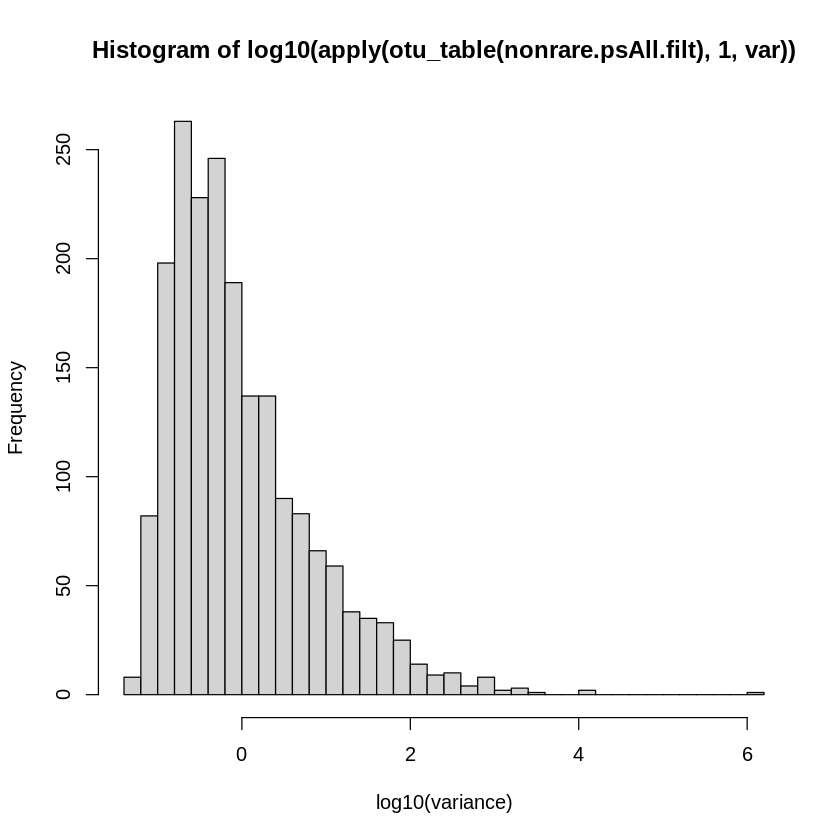

In [7]:
# #relative abundances
hist(log10(apply(otu_table(nonrare.psAll.filt), 1, var)),
     xlab="log10(variance)",breaks=50)#,
     #main="A large fraction of OTUs have very low variance")

## 1. Host vs. environmental

In [8]:
#Perform differentially abundance analysis
edger.host.env = runEdgeR(nonrare.psAll.filt,groupToCompare="biome_1")

In [9]:
#Table with DA flagellins
sigtab.host.env = edger.host.env$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.host.env = edger.host.env$sigtabgen

In [10]:
nrow(sigtabgen.host.env)

[1] 623

In [11]:
sigtab.host.env = sigtab.host.env %>%
    mutate(EnrichedIn=ifelse(logFC>0,"Host-associated","Environmental"))

In [12]:
names(sigtab.host.env)

[1] "Domain"     "Phylum"     "Class"      "Order"      "Family"    
 [6] "Genus"      "Species"    "logFC"      "logCPM"     "PValue"    
[11] "FDR"        "EnrichedIn"

#### Export list of Differentially Abundant flagellins

In [14]:
DA.biome1 = rownames_to_column(sigtab.host.env,var = "Accession")
write_tsv(DA.biome1,"subsampled_opt1/DA.host.env.tsv")

In [15]:
DA.env = filter(DA.biome1,EnrichedIn=="Environmental")
DA.host = filter(DA.biome1,EnrichedIn=="Host-associated")

In [19]:
write_tsv(DA.env, "subsampled_opt1/cds/DA.env.tsv")
write_tsv(DA.host, "subsampled_opt1/cds/DA.host.tsv")

write_lines(DA.env$Accession,"subsampled_opt1/cds/accn.DA.env.tsv")
write_lines(DA.host$Accession,"subsampled_opt1/cds/accn.DA.host.tsv")

In [13]:
cols.biomes = read_tsv("../../FlagellinDiversity/Figures/colors.map.tsv")

Rows: 11 Columns: 2
── Column specification ─────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): biome, color

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Plots

##### A. Phylum-level

In [84]:
cols.biomes

biome           color    
1  Environmental   #E64B35FF
2  Host-associated #4DBBD5FF
3  Plants          #00A087FF
4  Animal          #3C5488FF
5  Actinopterygii  #F39B7FFF
6  Reptilia        #8491B4FF
7  Amphibia        #91D1C2FF
8  Aves            #DC0000FF
9  Mammals         #7E6148FF
10 Aquatic         #33d9b2  
11 Terrestrial     #34ace0

In [29]:
nrow(sigtabgen.host.env)

[1] 623

In [53]:
write_tsv(sigtabgen.host.env,"sigtabgen.host.env.tsv")

Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Duplicated aesthetics after name standardisation: yend”


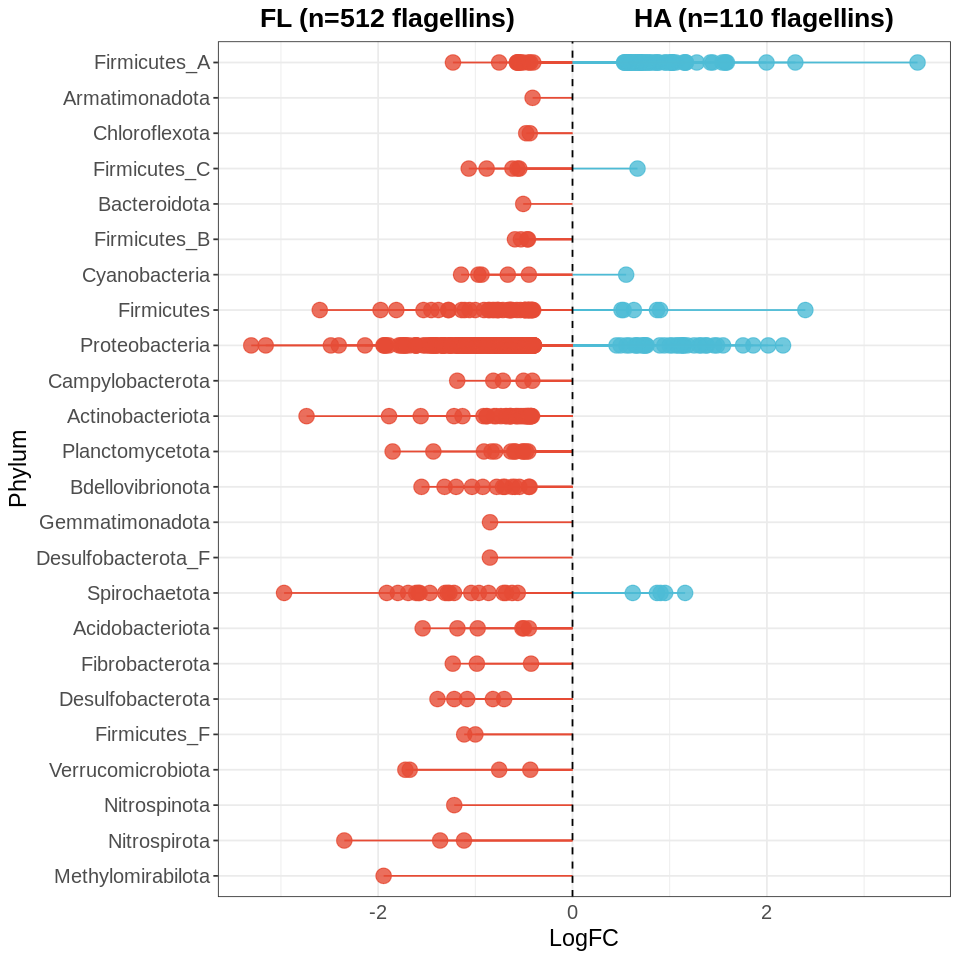

In [27]:
options(repr.plot.width=8,repr.plot.height=8)
ggplot(sigtabgen.host.env %>% mutate(Phylum=str_remove_all(Phylum,"p__")), 
       aes(y = reorder(Phylum,logFC), x = logFC, color=factor(sign(logFC))))+
    geom_point(size=4, alpha=0.8) + 
    theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Phylum,yend=Phylum),size=0.5)+
  geom_vline(xintercept = 0, size=0.5, linetype="dashed") +
  scale_color_manual(values = c("#E64B35FF", "#4DBBD5FF"), labels = c("LogFC < 0", "LogFC > 0"))+
  theme(axis.text.x = element_text(size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +

  ggtitle("      FL (n=512 flagellins)                 HA (n=110 flagellins) ")+ #  ggtitle("FL (DA=512)  HA (DA=110)")+
  labs(x = "LogFC", y = "Phylum")

In [21]:
shared.sigtabgen.host.env = filter(sigtabgen.host.env,Phylum%in%c("p__Cyanobacteria","p__Spirochaetota","p__Proteobacteria","p__Firmicutes","p__Firmicutes_A"))

##### A. Family-level

Warning message:
“Duplicated aesthetics after name standardisation: yend”


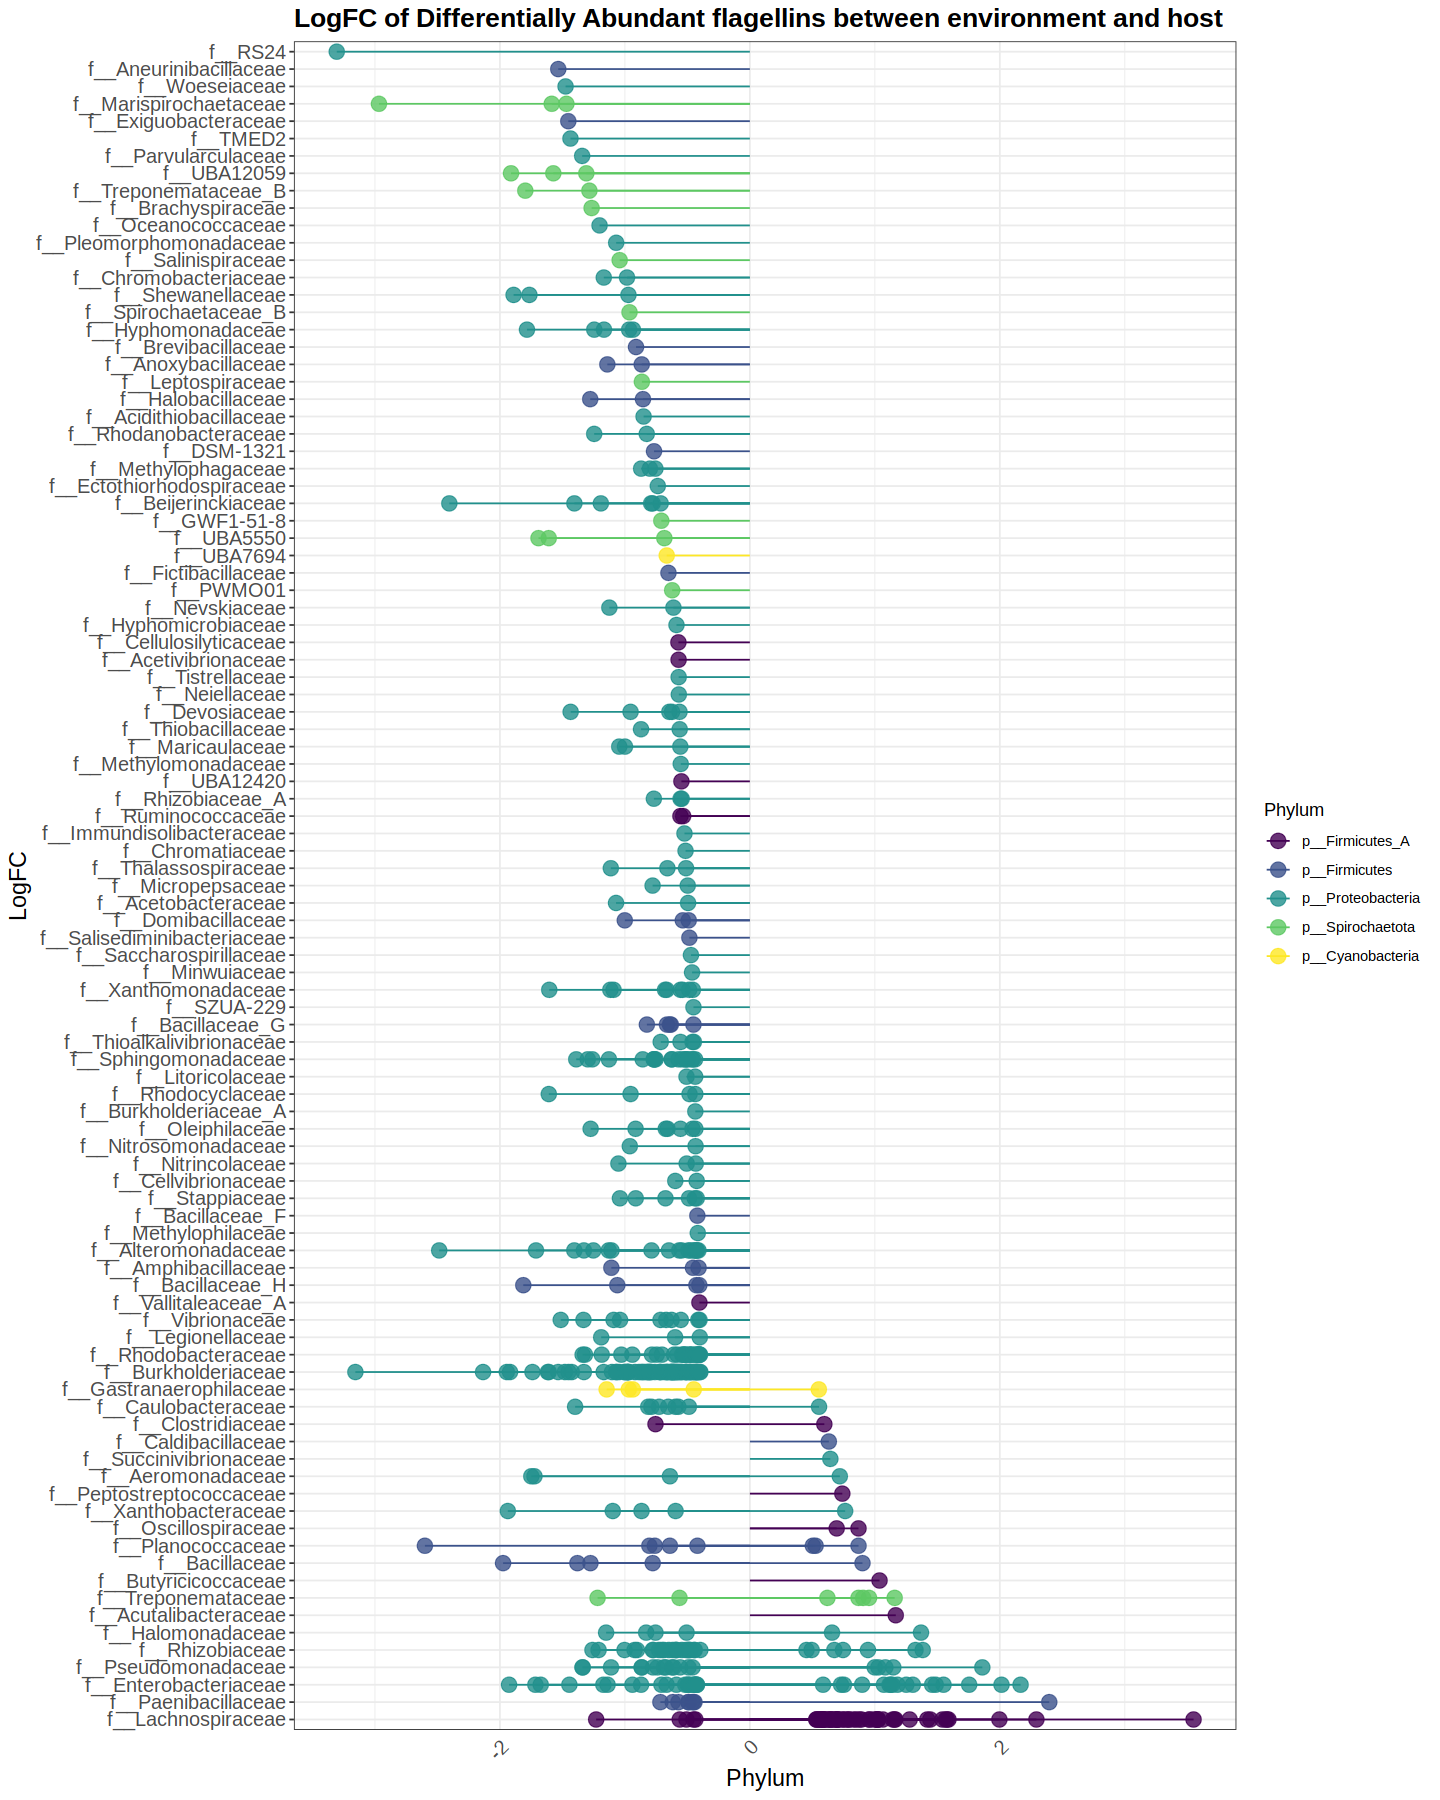

In [139]:
options(repr.plot.width=12,repr.plot.height=15)

ggplot(data = shared.sigtabgen.host.env, 
       aes(y = Family, x = logFC, color = Phylum)) + 
    geom_point(size=4, alpha=0.8) + 
    theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Family,yend=Family),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14))+#,
#       legend.position="none") +
  ggtitle("LogFC of Differentially Abundant flagellins between environment and host")+
  labs(x = "Phylum", y = "LogFC")

In [46]:
#Subset the phyloseq with the DA flagellins in biome_1
DAs.biome1=rownames(sigtab.host.env)
psDA_biome1 = prune_taxa(DAs.biome1,nonrare.psAll.filt)
psDA_biome1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 623 taxa and 352 samples ]
sample_data() Sample Data:       [ 352 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 623 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 623 tips and 622 internal nodes ]

#### Create heatmap with DA flagellins

In [51]:
annotations.biome1 = annotationsForHeatmap(psDA_biome1)

ERROR: Error in data.frame(sample = ps_obj@sam_data$Sample, biome1 = ps_obj@sam_data$biome_1, : arguments imply differing number of rows: 352, 0


In [48]:
matrix = createMatrixForHetmap(psDA_biome1)

In [49]:
options(repr.plot.width=15,repr.plot.height=8)
pheatmap(matrix, cutree_cols = 10,
         cluster_cols=TRUE,
         cluster_rows=FALSE,
         show_rownames=F,
         show_colnames=F,
         labels_row=annotations.biome1$annotation.row$Phylum,
         annotation_col=select(annotations.biome1$annotation.col,c(biome1)),
          color = viridis(n = 256, alpha = 1, 
                                   begin = 0, end = 1, option = "viridis")
)

ERROR: Error in pheatmap(matrix, cutree_cols = 10, cluster_cols = TRUE, cluster_rows = FALSE, : object 'annotations.biome1' not found


## 2. Animals/Environmental

In [55]:
ps.animals.env=subset_samples(nonrare.psAll.filt,category!="Plants")
ps.animals.env

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1971 taxa and 277 samples ]
sample_data() Sample Data:       [ 277 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1971 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1971 tips and 1970 internal nodes ]

In [56]:
#Perform differentially abundance analysis
edger.animal.env = runEdgeR(ps.animals.env,groupToCompare="category")

In [57]:
#Table with DA flagellins
sigtab.animal.env = edger.animal.env$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.animal.env = edger.animal.env$sigtabgen

In [58]:
nrow(sigtabgen.animal.env)

[1] 609

In [59]:
sigtab.animal.env = sigtab.animal.env %>%
    mutate(EnrichedIn=ifelse(logFC>0,"Environmental","Animals"))

#### Export list of Differentially Abundant flagellins

In [33]:
DA.animals.env = rownames_to_column(sigtab.animal.env,var = "Accession")
write_tsv(DA.animals.env,"subsampled_opt1/DA.animals.env.tsv")

In [60]:
tmp.env1 = filter(DA.animals.env,EnrichedIn=="Environmental")
tmp.env2 = filter(DA.plants.env,EnrichedIn=="Environmental")
tmp.env3 = filter(DA.biome1,EnrichedIn=="Environmental")
int.env = intersect(tmp.env1$Accession,tmp.env2$Accession) %>%
        intersect(tmp.env3$Accession)

ERROR: Error in filter(DA.animals.env, EnrichedIn == "Environmental"): object 'DA.animals.env' not found


In [ ]:
nrow(tmp.env1)
nrow(tmp.env2)
length(int.env)

#### Plots

##### A. Phylum-level

Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Duplicated aesthetics after name standardisation: yend”


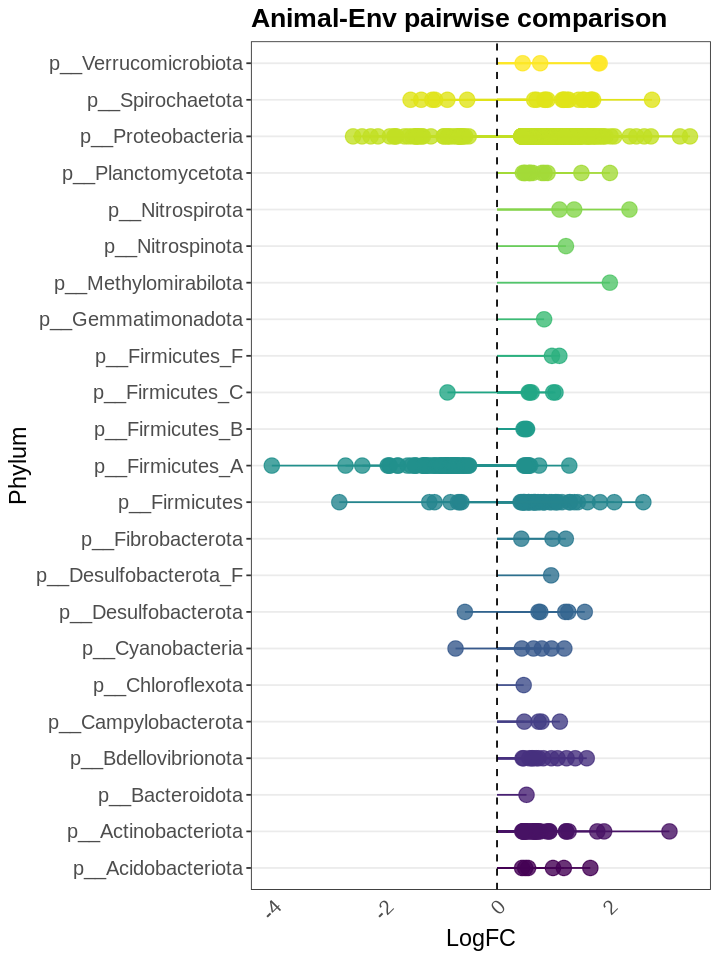

In [61]:
options(repr.plot.width=6,repr.plot.height=8)
ggplot(sigtabgen.animal.env, aes(y = Phylum, x = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Phylum,yend=Phylum),size=0.5)+
  geom_vline(xintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("Animal-Env pairwise comparison")+
  labs(y = "Phylum", x = "LogFC")

In [62]:
head(sigtabgen.animal.env)

Domain      Phylum              Class                 
EEJ52905.1     d__Bacteria p__Actinobacteriota c__Actinomycetia      
OUT94870.1     d__Bacteria p__Proteobacteria   c__Alphaproteobacteria
KQT19785.1     d__Bacteria p__Proteobacteria   c__Alphaproteobacteria
KDR32911.1     d__Bacteria p__Proteobacteria   c__Gammaproteobacteria
OAS88434.1     d__Bacteria p__Proteobacteria   c__Gammaproteobacteria
WP_068024403.1 d__Bacteria p__Proteobacteria   c__Alphaproteobacteria
               Order              Family               Genus              
EEJ52905.1     o__Actinomycetales f__Actinomycetaceae  g__Mobiluncus      
OUT94870.1     o__Parvibaculales  f__RS24              g__UBA7378         
KQT19785.1     o__Rhizobiales     f__Beijerinckiaceae  g__Methylobacterium
KDR32911.1     o__Burkholderiales f__Burkholderiaceae  g__Caballeronia    
OAS88434.1     o__Burkholderiales f__Burkholderiaceae  g__Achromobacter   
WP_068024403.1 o__Rhizobiales     f__Xanthobacteraceae g__Z2-YC6860       
               Species                         logFC    logCPM   PValue      
EEJ52905.1     s__Mobiluncus mulieris          3.080322 11.98937 5.780637e-75
OUT94870.1     s__UBA7378 sp002689195          3.446868 11.46430 7.556581e-64
KQT19785.1     s__Methylobacterium sp001423265 2.750747 11.26181 5.330136e-60
KDR32911.1     s__Caballeronia zhejiangensis   3.268495 14.43158 1.497735e-52
OAS88434.1     s__Achromobacter xylosoxidans   2.372564 11.40918 1.161668e-42
WP_068024403.1 s__Z2-YC6860 sp001579845        2.629497 11.07332 1.590802e-40
               FDR          EnrichedIn   
EEJ52905.1     1.138786e-71 Environmental
OUT94870.1     7.443232e-61 Environmental
KQT19785.1     3.500123e-57 Environmental
KDR32911.1     7.376344e-50 Environmental
OAS88434.1     4.576974e-40 Environmental
WP_068024403.1 5.223134e-38 Environmental

In [63]:
lachnos.env.animals =filter(sigtabgen.animal.env,Family%in%"f__Lachnospiraceae")

In [64]:
nrow(lachnos.env.animals)

[1] 68

Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”


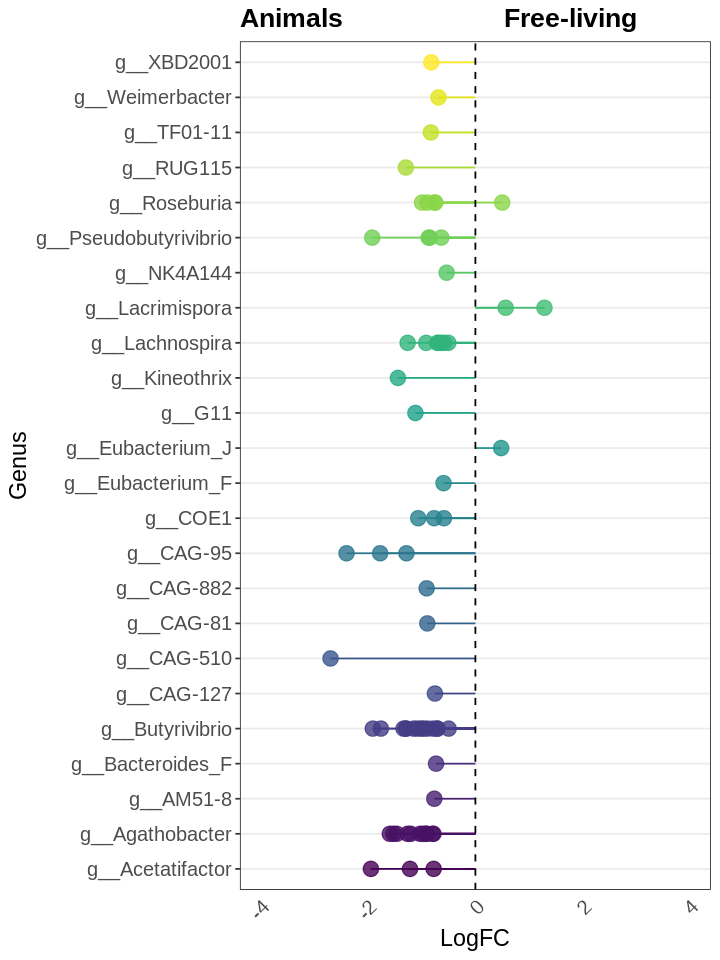

In [65]:
options(repr.plot.width=6,repr.plot.height=8)
ggplot(lachnos.env.animals, aes(y = Genus, x = logFC, color = Genus)) +geom_point(size=4, alpha=0.8) + 
  theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Genus,yend=Genus),size=0.5)+
  geom_vline(xintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("Animals                       Free-living")+
  labs(y = "Genus", x = "LogFC")+
xlim(-4,4)

## 3. Plants/Environmental

In [66]:
ps.plants.env=subset_samples(nonrare.psAll.filt,category!="Animal")
ps.plants.env

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1971 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1971 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1971 tips and 1970 internal nodes ]

In [67]:
#Perform differentially abundance analysis
edger.plants.env = runEdgeR(ps.plants.env,groupToCompare="category")

In [68]:
#Table with DA flagellins
sigtab.plants.env = edger.plants.env$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.plants.env = edger.plants.env$sigtabgen

In [69]:
nrow(sigtabgen.plants.env)

[1] 326

In [70]:
sigtab.plants.env = sigtab.plants.env %>%
    mutate(EnrichedIn=ifelse(logFC>0,"Plants","Environmental"))

In [71]:
head(sigtab.plants.env)

Domain      Phylum            Class                 
KDR32911.1 d__Bacteria p__Proteobacteria c__Gammaproteobacteria
SFH83235.1 d__Bacteria p__Firmicutes_A   c__Clostridia         
EHS52757.1 d__Bacteria p__Proteobacteria c__Alphaproteobacteria
EHS53752.1 d__Bacteria p__Proteobacteria c__Alphaproteobacteria
EEO87047.1 d__Bacteria p__Proteobacteria c__Gammaproteobacteria
OUT94870.1 d__Bacteria p__Proteobacteria c__Alphaproteobacteria
           Order               Family                Genus                
KDR32911.1 o__Burkholderiales  f__Burkholderiaceae   g__Caballeronia      
SFH83235.1 o__Lachnospirales   f__Lachnospiraceae    g__Pseudobutyrivibrio
EHS52757.1 o__Rhizobiales      f__Rhizobiaceae       g__Allorhizobium     
EHS53752.1 o__Rhizobiales      f__Rhizobiaceae       g__Allorhizobium     
EEO87047.1 o__Enterobacterales f__Enterobacteriaceae g__Yersinia          
OUT94870.1 o__Parvibaculales   f__RS24               g__UBA7378           
           Species                           logFC     logCPM   PValue      
KDR32911.1 s__Caballeronia zhejiangensis     -2.908576 14.93526 1.936465e-38
SFH83235.1 s__Pseudobutyrivibrio sp900113655  2.904689 11.13411 5.201127e-31
EHS52757.1 s__Allorhizobium sp000247475       2.709735 11.06175 4.533335e-26
EHS53752.1 s__Allorhizobium sp000247475       2.598008 10.93431 1.415750e-25
EEO87047.1 s__Yersinia pestis                -2.229251 11.42780 3.492954e-25
OUT94870.1 s__UBA7378 sp002689195            -3.005981 11.87206 1.206600e-21
           FDR          EnrichedIn   
KDR32911.1 3.783853e-35 Environmental
SFH83235.1 5.081501e-28 Plants       
EHS52757.1 2.952712e-23 Plants       
EHS53752.1 6.915937e-23 Plants       
EEO87047.1 1.365046e-22 Environmental
OUT94870.1 3.495374e-19 Environmental

#### Export list of Differentially Abundant flagellins

In [51]:
DA.plants.env = rownames_to_column(sigtab.plants.env,var = "Accession")
write_tsv(DA.plants.env,"subsampled_opt1/DA.plants.env.tsv")

#### Plots

##### A. Phylum-level

Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Duplicated aesthetics after name standardisation: yend”


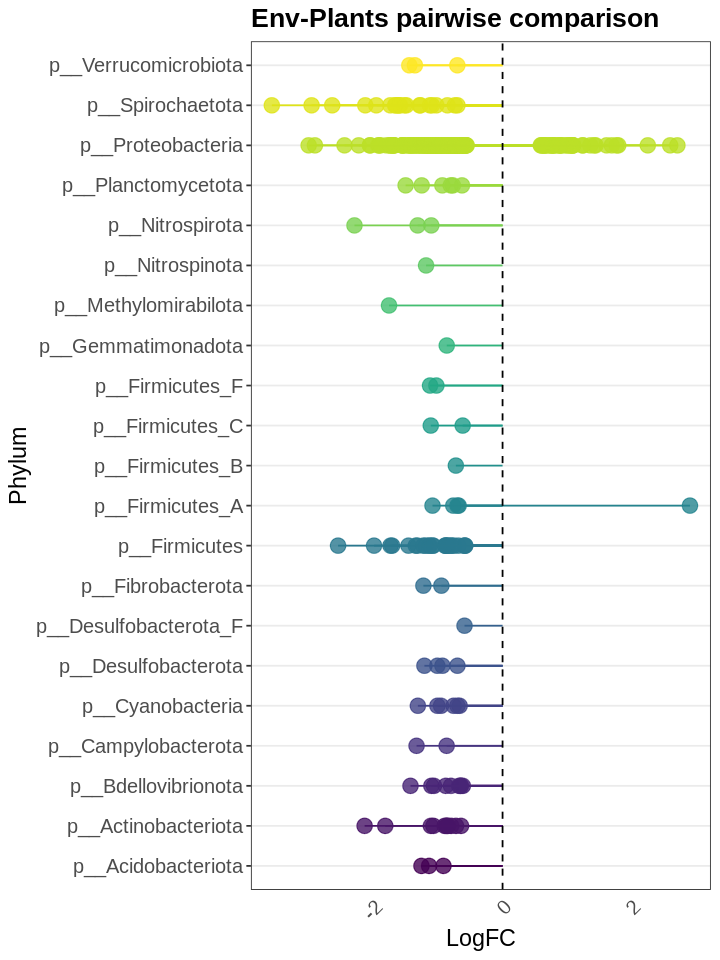

In [72]:
ggplot(sigtabgen.plants.env, aes(y = Phylum, x = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
  theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Phylum,yend=Phylum),size=0.5)+
  geom_vline(xintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none") +
  ggtitle("Env-Plants pairwise comparison")+
  labs(y = "Phylum", x = "LogFC")

## 4. Plants vs. animals

In [73]:
subset.host.nonrare.filt=subset_samples(nonrare.psAll.filt,biome_1=="Host-associated")

In [74]:
#Perform differentially abundance analysis
edger.host = runEdgeR(subset.host.nonrare.filt,groupToCompare="category")

In [75]:
#Table with DA flagellins
sigtab.host = edger.host$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.host = edger.host$sigtabgen

In [76]:
nrow(sigtab.host)

[1] 203

In [77]:
sigtab.host = sigtab.host %>%
    mutate(EnrichedIn=ifelse(logFC>0,"Plants","Animals"))
head(sigtab.host)

Domain      Phylum            Class                 
SFH83235.1 d__Bacteria p__Firmicutes_A   c__Clostridia         
EHS52757.1 d__Bacteria p__Proteobacteria c__Alphaproteobacteria
EHS53753.1 d__Bacteria p__Proteobacteria c__Alphaproteobacteria
EHS53752.1 d__Bacteria p__Proteobacteria c__Alphaproteobacteria
PYB77514.1 d__Bacteria p__Proteobacteria c__Alphaproteobacteria
KPF42046.1 d__Bacteria p__Proteobacteria c__Alphaproteobacteria
           Order             Family             Genus                
SFH83235.1 o__Lachnospirales f__Lachnospiraceae g__Pseudobutyrivibrio
EHS52757.1 o__Rhizobiales    f__Rhizobiaceae    g__Allorhizobium     
EHS53753.1 o__Rhizobiales    f__Rhizobiaceae    g__Allorhizobium     
EHS53752.1 o__Rhizobiales    f__Rhizobiaceae    g__Allorhizobium     
PYB77514.1 o__Rhizobiales    f__Rhizobiaceae    g__Allorhizobium     
KPF42046.1 o__Rhizobiales    f__Rhizobiaceae    g__Allorhizobium     
           Species                           logFC    logCPM   PValue      
SFH83235.1 s__Pseudobutyrivibrio sp900113655 2.884722 11.08710 1.264558e-52
EHS52757.1 s__Allorhizobium sp000247475      2.741936 11.02470 1.162711e-45
EHS53753.1 s__Allorhizobium sp000247475      2.662170 11.01887 9.249745e-44
EHS53752.1 s__Allorhizobium sp000247475      2.546891 10.93027 1.695101e-41
PYB77514.1 s__Allorhizobium wuzhouense       1.825485 10.66818 5.888295e-28
KPF42046.1 s__Allorhizobium sp001296045      1.667280 10.63215 7.724394e-26
           FDR          EnrichedIn
SFH83235.1 2.489915e-49 Plants    
EHS52757.1 1.144689e-42 Plants    
EHS53753.1 6.070916e-41 Plants    
EHS53752.1 8.344137e-39 Plants    
PYB77514.1 2.318811e-25 Plants    
KPF42046.1 2.534889e-23 Plants

##### Export list of Differentially Abundant flagellins

In [58]:
DA.animalsvsplants = rownames_to_column(sigtab.host,var = "Accession")
write_tsv(DA.animalsvsplants,"subsampled_opt1/DA.animal.plants.tsv")


In [59]:
#Export animal-enriched flagellins mapping file and accessions
write_tsv(filter(DA.animalsvsplants,EnrichedIn=="Animals"), "subsampled_opt1/DA.animals.tsv")
write_lines(filter(DA.animalsvsplants,EnrichedIn=="Animals")$Accession,"subsampled_opt1/accn.DA.animals.tsv")

#Export plants-enriched flagellins mapping file and accessions
write_tsv(filter(DA.animalsvsplants,EnrichedIn=="Plants"), "subsampled_opt1/DA.plants.tsv")
write_lines(filter(DA.animalsvsplants,EnrichedIn=="Plants")$Accession,"subsampled_opt1/accn.DA.plants.tsv")


#### Plots

##### A. Phlyum-level

In [78]:
count(sigtabgen.host,logFC<0)

logFC < 0 n  
1 FALSE      82
2  TRUE     121

In [83]:
write_tsv(sigtabgen.host,"sigtabgen.host.tsv")

Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”


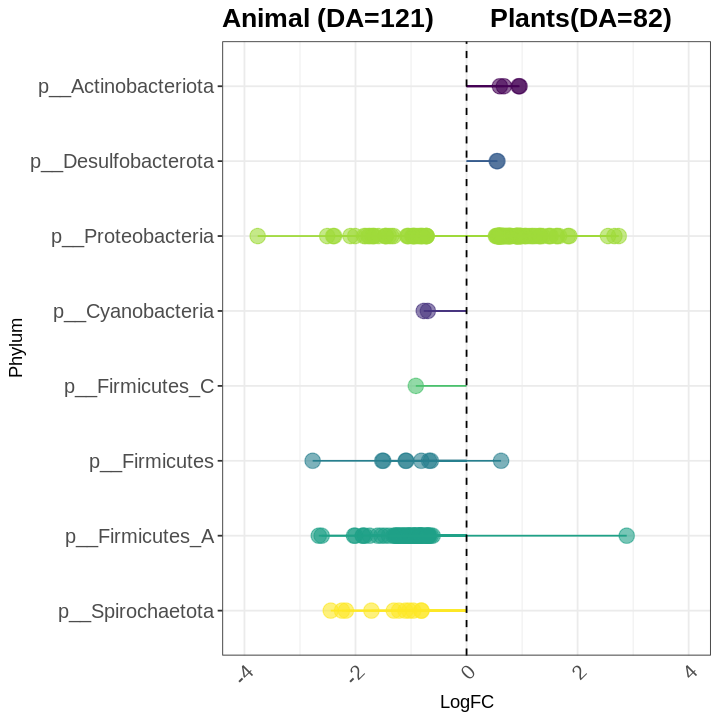

In [80]:
options(repr.plot.width=6,repr.plot.height=6)

ggplot(sigtabgen.host, aes(y = reorder(Phylum,logFC), x = logFC, color = Phylum)) +geom_point(size=4, alpha=0.6) + 
theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Phylum,yend=Phylum),size=0.5)+
  geom_vline(xintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       legend.position="none") +
    labs(y = "Phylum", x = "LogFC")+
xlim(-4,4)+
ggtitle("Animal (DA=121)        Plants(DA=82)")

##### B. Family-level

In [62]:
count(sigtabgen.host,logFC<0)

logFC < 0 n  
1 FALSE      82
2  TRUE     121

In [88]:
library(RColorBrewer)

In [110]:
okabe_ito_palette <- c("#E69F00", # orange
                       "#56B4E9", # sky blue
                       "#009E73", # bluish green
                       "#F0E442", # yellow
                       "#0072B2", # blue
                       "#D55E00", # vermillion
                       "#CC79A7", # reddish purple
                       "#999999") # grey
                       #"#000000") # black

Warning message in brewer.pal(9, "Set2"):
“n too large, allowed maximum for palette Set2 is 8
Returning the palette you asked for with that many colors
”


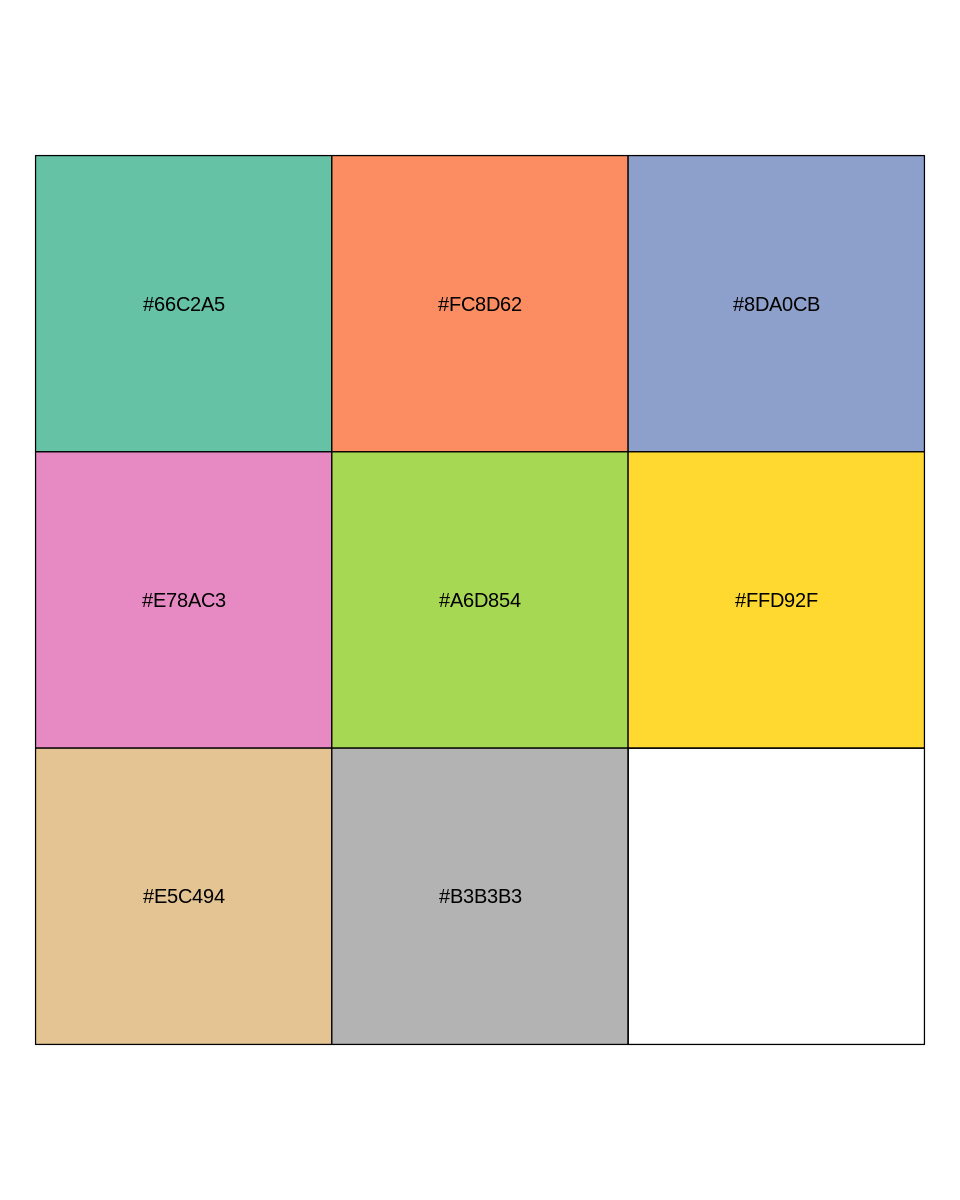

In [136]:
color_palette <- brewer.pal(9, "Set2")
scales::show_col(color_palette)

In [171]:
phylum.colors = count(sigtabgen.host,Phylum) %>% 
select(Phylum) %>%
mutate(color = color_palette[1:8])#okabe_ito_palette)

In [169]:
sigtabgen.host  = sigtabgen.host %>%
                    mutate(Family = str_remove_all(Family,"f__")) %>%
                    mutate(Phylum = str_remove_all(Phylum,"p__")) %>%
                    mutate(Genus = str_remove_all(Genus,"g__"))

Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Duplicated aesthetics after name standardisation: yend”


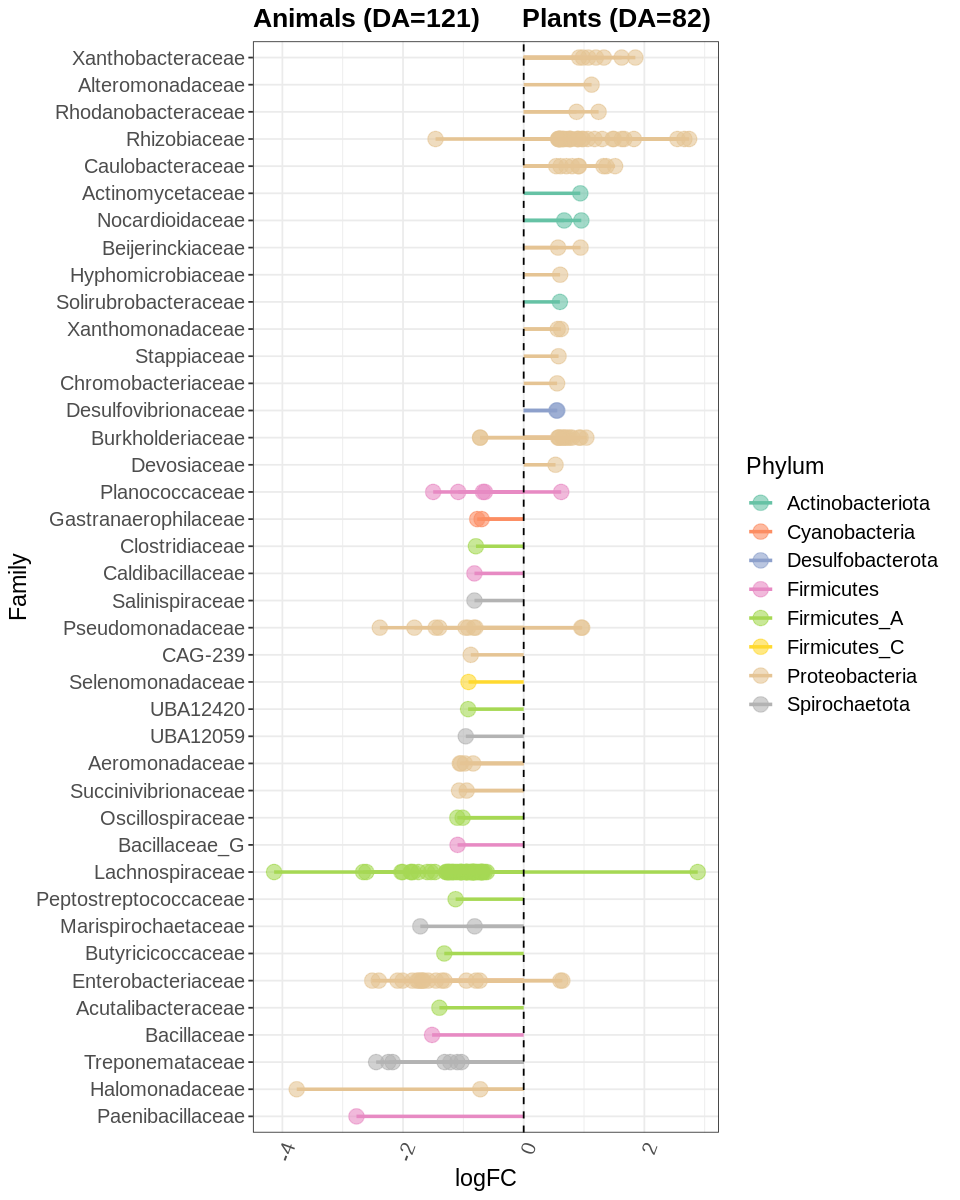

In [220]:
options(repr.plot.width=8,repr.plot.height=10)

#png(file="../../FlagellinDiversity/Figures/Fig10_panelA.png")#,width=12,height=6)
#fig10.a = ggplot(sigtabgen.host,aes(y = reorder(Family,logFC), x = logFC, color = Phylum)) + geom_point(size=4,alpha=0.6) + 
theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Family,yend=Family),size=1)+
  geom_vline(xintercept = 0, size=0.5, linetype="dashed") +
  scale_color_manual(values = phylum.colors$color,
                    limits = phylum.colors$Phylum)+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="right",) +
  ggtitle("Animals (DA=121)      Plants (DA=82)")+
ylab("Family")
#dev.off() 

In [214]:
tmp.non.sh = filter(sigtabgen.host,!Phylum%in%c("Firmicutes","Proteobacteria","Firmicutes_A"))

In [216]:
count(tmp.non.sh,logFC<0)

logFC < 0 n 
1 FALSE      6
2  TRUE     14

In [223]:
tmp.phylum.colors = phylum.colors %>%
                    filter(!Phylum%in%c("Firmicutes","Proteobacteria","Firmicutes_A"))

In [297]:
options(repr.plot.width=8,repr.plot.height=8)

#png(file="../../FlagellinDiversity/Figures/Fig10_panelA.png")#,width=12,height=6)
fig10.a = ggplot(tmp.non.sh,aes(y = reorder(Family,logFC), x = logFC, color = Phylum)) + geom_point(size=4,alpha=0.6) + 
theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Family,yend=Family),size=1)+
  geom_vline(xintercept = 0, size=0.5, linetype="dashed") +
  scale_color_manual(values = tmp.phylum.colors$color,
                    limits = tmp.phylum.colors$Phylum)+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="top",
       plot.margin = unit(c(0.3,0.3,0.3,0.3),"cm")) +
  ggtitle("Animals (DA=14)      Plants (DA=6)")+
    ylab("Family")+
    xlim(c(-3,3))+
    guides(color = guide_legend(nrow = 2,ncol=3))
#dev.off() 

Warning message:
“Duplicated aesthetics after name standardisation: yend”


In [180]:
ggplot(sigtabgen.host, aes(x = logFC, y = reorder(Family, logFC), fill = Phylum)) +
  ggridges::geom_ridgeline(alpha = 0.8, scale = 0.9) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "gray50") +
  scale_fill_manual(values = phylum.colors$color) +
  labs(title = "Differentially Abundant Flagellins: Animals vs. Plants",
       x = "Log Fold Change (logFC)",
       y = "Family") +
  theme_ridges() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        plot.title = element_text(size = 16, face = "bold"),
        legend.position = "right")

ERROR: Error in theme_ridges(): could not find function "theme_ridges"


In [148]:
#Subset of shared flagellins between plants-animals
tmp1 = filter(DA.animalsvsplants,Phylum%in%c("p__Firmicutes","p__Proteobacteria","p__Firmicutes_A"))

In [156]:
### summarize flagellins from shared phyla between plants and animals

In [153]:
listEnrichedBiomes = list(plants=filter(tmp1,EnrichedIn=="Plants"),animals=filter(tmp1,EnrichedIn=="Animals"))

In [154]:
taxSummary = lapply(listEnrichedBiomes,getTaxSummary)

In [155]:
taxSummBiomes = bind_rows(taxSummary)
taxSummBiomes

EnrichedIn totalEnriched NoPhyla NoClass NoOrder NoFamily NoGenus NoSpecies
1 Plants      76           3       4        8      16       34      65       
2 Animals    107           3       4       13      20       47      74

In [185]:
phylum.colors

Phylum           color  
1 Actinobacteriota #66C2A5
2 Cyanobacteria    #FC8D62
3 Desulfobacterota #8DA0CB
4 Firmicutes       #E78AC3
5 Firmicutes_A     #A6D854
6 Firmicutes_C     #FFD92F
7 Proteobacteria   #E5C494
8 Spirochaetota    #B3B3B3

In [296]:
options(repr.plot.width=8,repr.plot.height=10)
tmp.colors = filter(phylum.colors,Phylum%in%c("Firmicutes","Proteobacteria","Firmicutes_A"))
#png(file="../../FlagellinDiversity/Figures/figure10_panelB.png")#,width=12,height=6)
fig10.b = ggplot(filter(sigtabgen.host,Phylum%in%c("Firmicutes","Proteobacteria","Firmicutes_A")), aes(y = reorder(Family,logFC), x = logFC, color = Phylum)) + geom_point(size=4,alpha=0.7) + 
theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Family,yend=Family),size=1)+
  geom_vline(xintercept = 0, size=0.5, linetype="dashed") +
  scale_color_manual(values=tmp.colors$color,
                     limits = tmp.colors$Phylum)+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="top",
       plot.margin = unit(c(0.3,0.3,0.3,0.3),"cm")) +
xlim(-4,4)+
  ggtitle("Animals (DA=107)    Plants (DA=76)")+
ylab("Family")+
guides(color = guide_legend(nrow = 2,ncol=3))
#guides(color = guide_legend(nrow = 2,ncol=3))
#dev.off() 


Warning message:
“Duplicated aesthetics after name standardisation: yend”


In [189]:
shared.fam = filter(sigtabgen.host,Family%in%c("Enterobacteriaceae",
                                         "Pseudomonadaceae",
                                         "Burkholderiaceae",
                                         "Rhizobiaceae",
                                         "Lachnospiraceae"))

In [190]:
count(shared.fam,logFC<0)

logFC < 0 n 
1 FALSE     48
2  TRUE     83

In [165]:
#Subset of shared flagellins between plants-animals
tmp2 = filter(DA.animalsvsplants,Family%in%c("f__Enterobacteriaceae",
                                         "f__Pseudomonadaceae",
                                         "f__Burkholderiaceae",
                                         "f__Rhizobiaceae",
                                         "f__Lachnospiraceae"))

In [159]:
### summarize flagellins from shared phyla between plants and animals

In [166]:
listEnrichedBiomes2 = list(plants=filter(tmp2,EnrichedIn=="Plants"),animals=filter(tmp2,EnrichedIn=="Animals"))

In [167]:
taxSummary2 = lapply(listEnrichedBiomes2,getTaxSummary)

In [168]:
taxSummBiomes2 = bind_rows(taxSummary2)
taxSummBiomes2

EnrichedIn totalEnriched NoPhyla NoClass NoOrder NoFamily NoGenus NoSpecies
1 Plants     48            2       3       5       5        20      38       
2 Animals    83            2       3       5       5        28      53

In [193]:
okabe_ito_palette <- c("#E69F00", # orange
                       "#56B4E9", # sky blue
                       "#009E73", # bluish green
                       "#F0E442", # yellow
                       "#0072B2", # blue
                       "#D55E00", # vermillion
                       "#CC79A7", # reddish purple
                       "#999999") # grey
                       #"#000000") # black

In [195]:
fam.colors = count(shared.fam,Family) %>% 
select(Family) %>%
mutate(color = okabe_ito_palette[1:5])#okabe_ito_palette)

In [447]:
fam.colors

Family             color  
1 Burkholderiaceae   #E69F00
2 Enterobacteriaceae #56B4E9
3 Lachnospiraceae    #009E73
4 Pseudomonadaceae   #F0E442
5 Rhizobiaceae       #0072B2

In [295]:
#options(repr.plot.width=8,repr.plot.height=10)

#png(file="plants.vs.animals.enriched.png",width=12,height=6)
fig10.c_horizontal = ggplot(shared.fam, 
       aes(x = reorder(Genus,logFC), y = logFC, color = Family)) + geom_point(size=4,alpha=0.6) + 
theme_bw()+
  geom_segment(aes(y=0,yend=logFC,xend=Genus,xend=Genus),size=1)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_manual(values = fam.colors$color,
                     limits = fam.colors$Family)+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="top",
       plot.margin = unit(c(0.3,0.3,0.3,0.3),"cm")) +
ylim(-4,4)+
  ggtitle("Animals (DA=83)  Plants (DA=48)")+
xlab("Genus")+
guides(color = guide_legend(nrow = 2,ncol=3))

#dev.off() 

Warning message:
“Duplicated aesthetics after name standardisation: xend”


In [276]:
library(scales)

In [262]:
#options(repr.plot.width=8,repr.plot.height=10)

#png(file="plants.vs.animals.enriched.png",width=12,height=6)
fig10.c_vertical = ggplot(shared.fam, 
       aes(y = reorder(Genus,logFC), x = logFC, color = Family)) + geom_point(size=4,alpha=0.6) + 
theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Genus,yend=Genus),size=1)+
  geom_vline(xintercept = 0, size=0.5, linetype="dashed") +
  scale_color_manual(values = fam.colors$color,
                     limits = fam.colors$Family)+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="top") +
ylim(-4,4)+
  ggtitle("Animals (DA=83)  Plants (DA=48)")+
ylab("Genus")+
guides(color = guide_legend(nrow = 2,ncol=3))

#dev.off() 

Warning message:
“Duplicated aesthetics after name standardisation: yend”


In [69]:
shared.genus = filter(sigtabgen.host,Genus%in%c("g__Pseudomonas_E",
                                         "g__Pseudobutyrivibrio"))


In [70]:
count(shared.genus,logFC<0)

logFC < 0 n 
1 FALSE      2
2  TRUE     11

In [71]:
shared.genus = rownames_to_column(shared.genus,var="Accession")


Warning message:
“Duplicated aesthetics after name standardisation: yend”


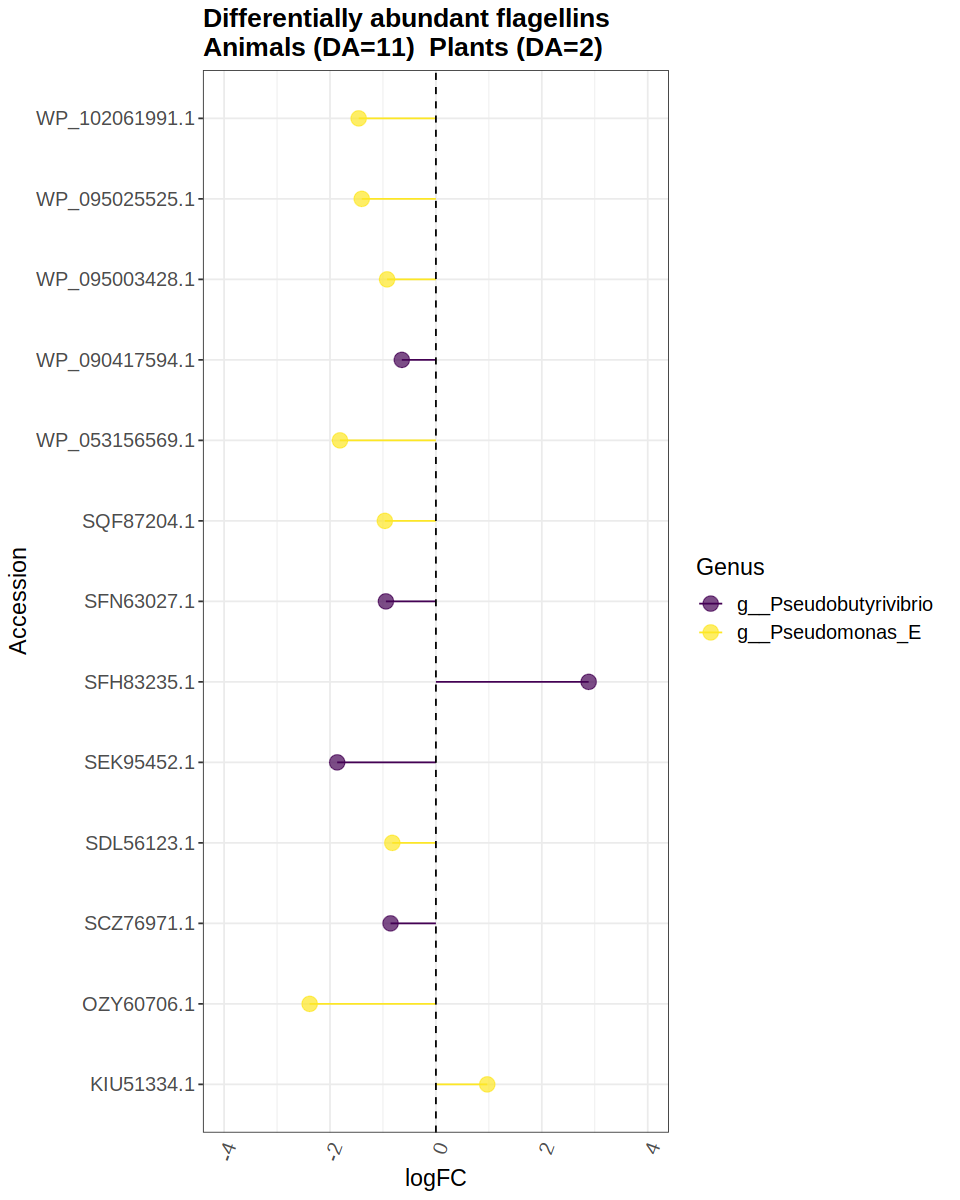

In [72]:
options(repr.plot.width=8,repr.plot.height=10)

#png(file="plants.vs.animals.enriched.png",width=12,height=6)
ggplot(shared.genus, 
       aes(y = Accession, x = logFC, color = Genus)) + geom_point(size=4,alpha=0.7) + 
theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Accession,yend=Accession),size=0.5)+
  geom_vline(xintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14)) +
xlim(-4,4)+
  ggtitle("Differentially abundant flagellins
Animals (DA=11)  Plants (DA=2)")
#dev.off() 

##### C. Genus-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”
Warning message:
“Duplicated aesthetics after name standardisation: xend”


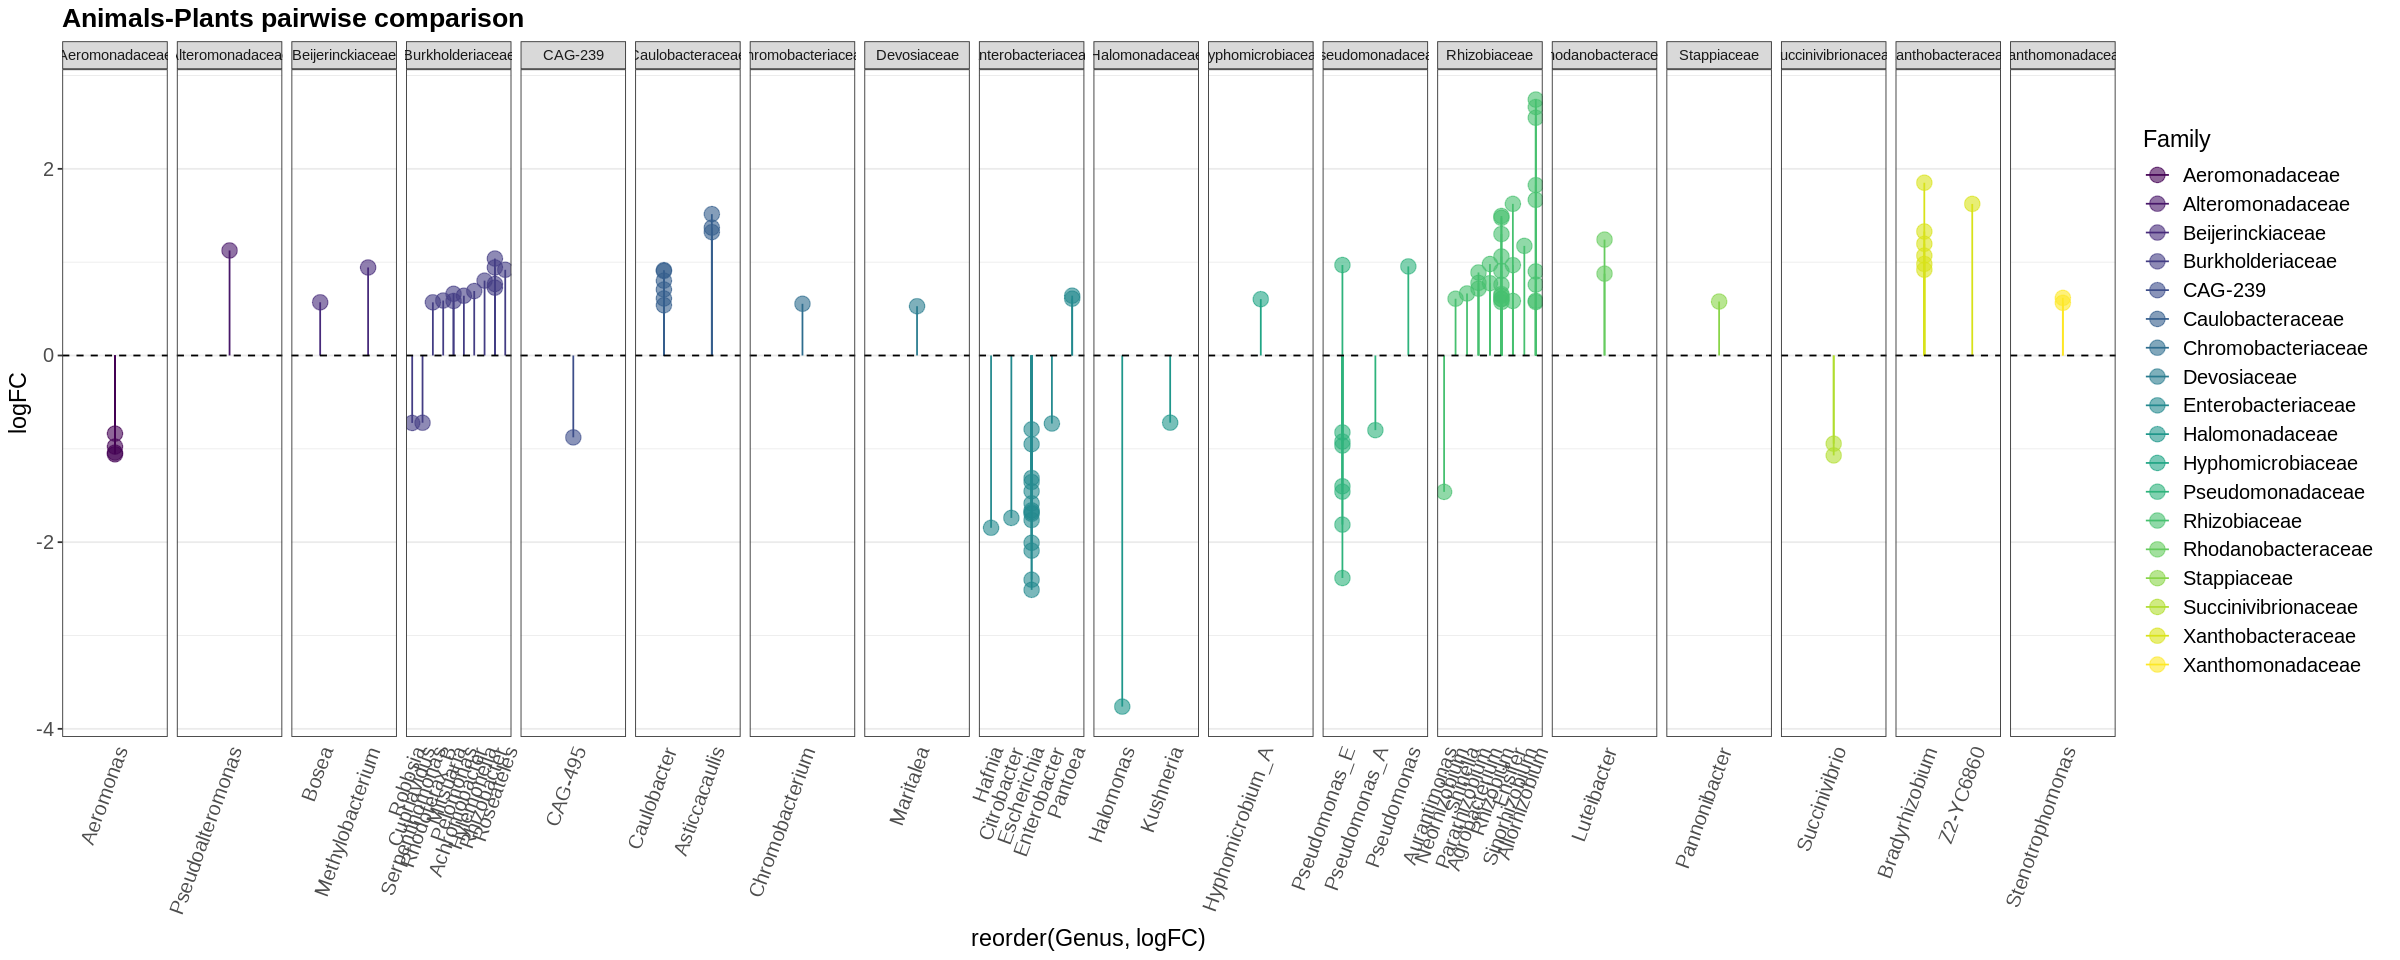

In [203]:
options(repr.plot.width=20,repr.plot.height=8)
ggplot(filter(sigtabgen.host,Phylum=="Proteobacteria"), aes(x = reorder(Genus,logFC), y = logFC, color = Family)) + geom_point(size=4,alpha=0.6) + 
theme_bw()+
  geom_segment(aes(y=0,yend=logFC,xend=Genus,xend=Genus),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14)) +
  ggtitle("Animals-Plants pairwise comparison")+
facet_grid(~Family,scales="free")

##### D. species-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”


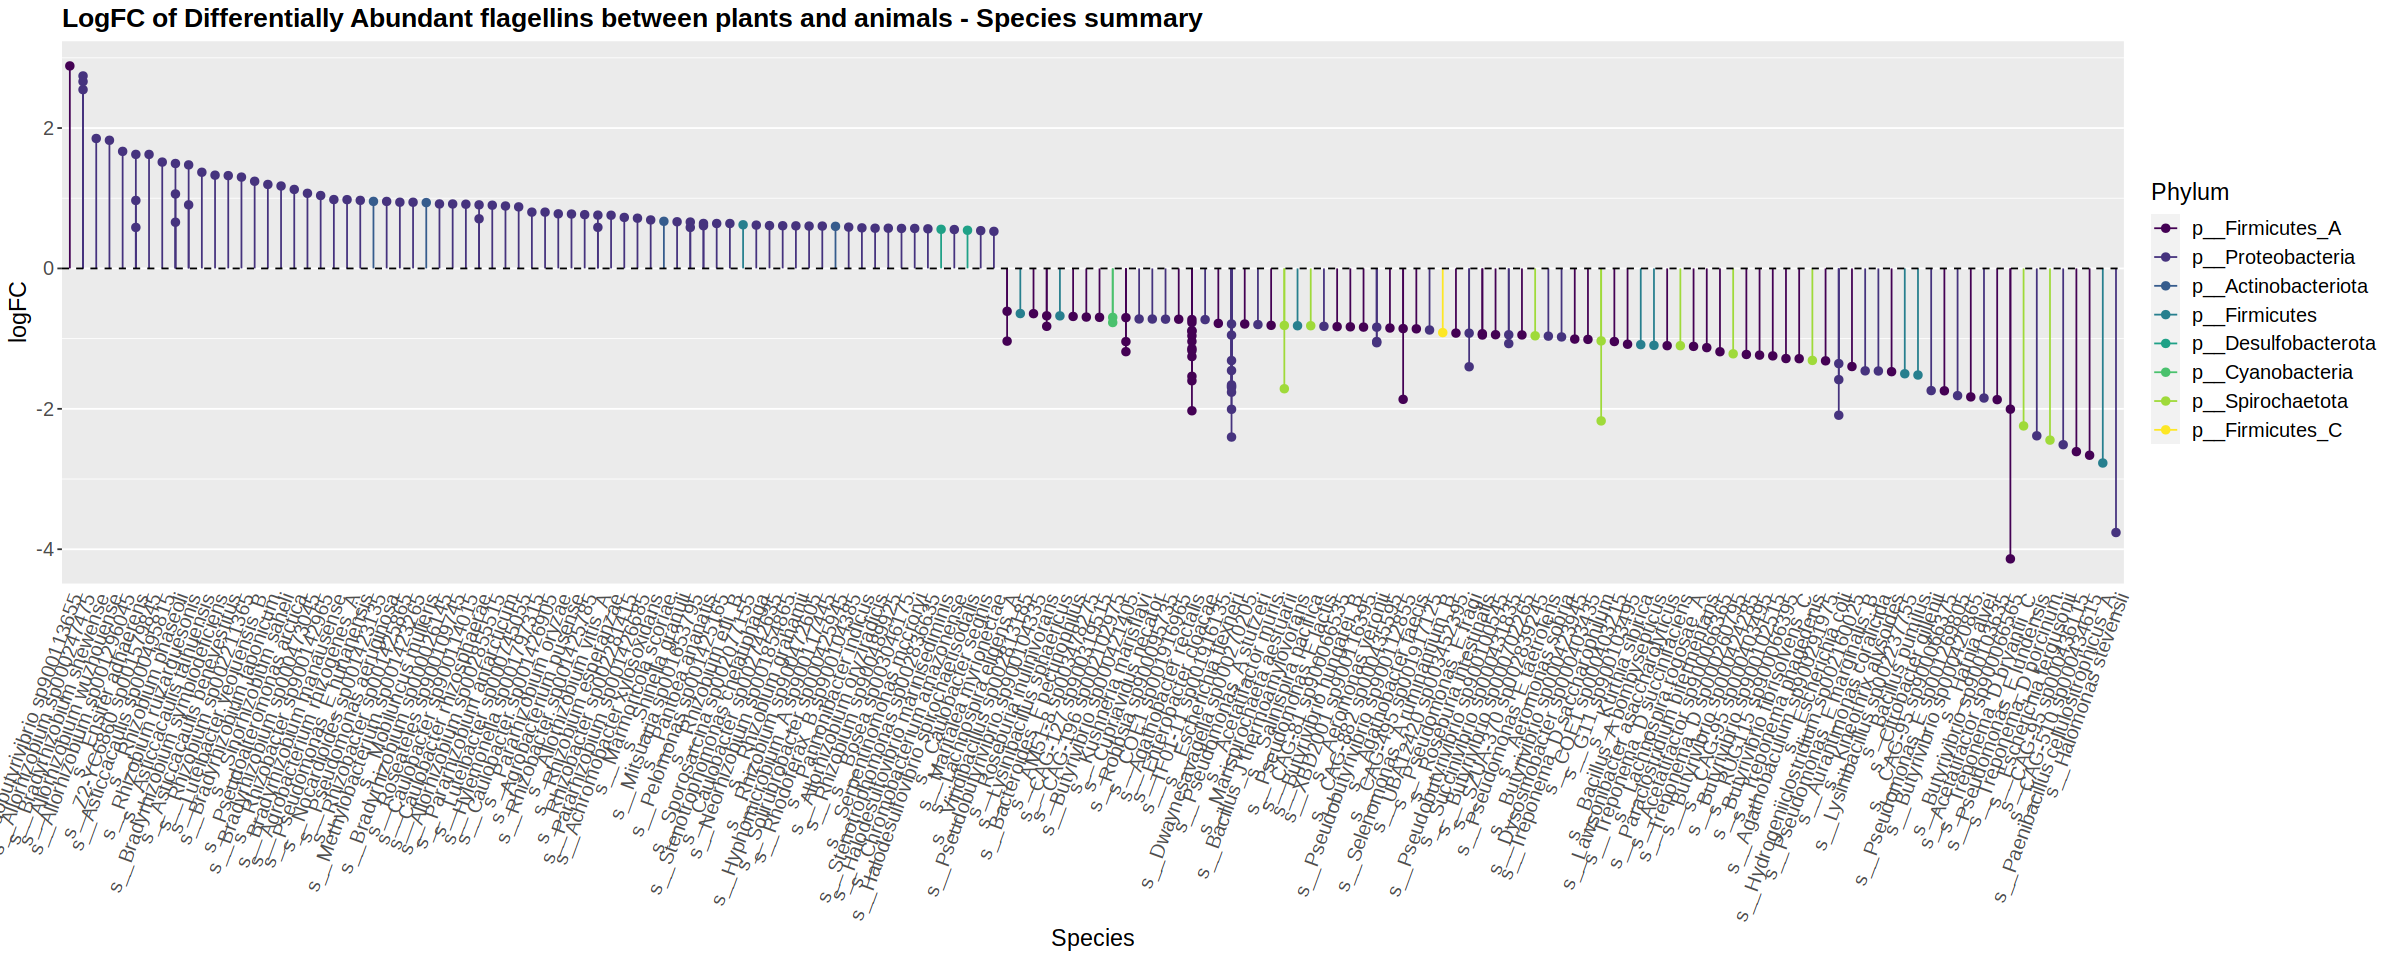

In [74]:
options(repr.plot.width=20,repr.plot.height=8)
ggplot(sigtabgen.host, aes(x = Species, y = logFC, color = Phylum)) + geom_point(size=2) + 
  geom_segment(aes(y=0,yend=logFC,xend=Species,xend=Species),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14)) +
  ggtitle("LogFC of Differentially Abundant flagellins between plants and animals - Species summary")

#### Figure thesis

In [209]:
figures_path="/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/FlagellinDiversity/Figures"

In [298]:
lay <- rbind(c(1,1,2,2),
             c(1,1,2,2),
             c(3,3,3,3),
             c(3,3,3,3))
grobs.plots = list(fig10.a,fig10.b,fig10.c_horizontal)

In [444]:
#file("/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/FlagellinDiversity/Figures/Figure1.pdf")
pdf(file.path(figures_path,"Figure10_2.pdf"), width = 14, height = 14)
grid.arrange(grobs = grobs.plots , layout_matrix = lay )
dev.off()

Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Duplicated aesthetics after name standardisation: xend”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”


png 
  2

Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Duplicated aesthetics after name standardisation: xend”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”


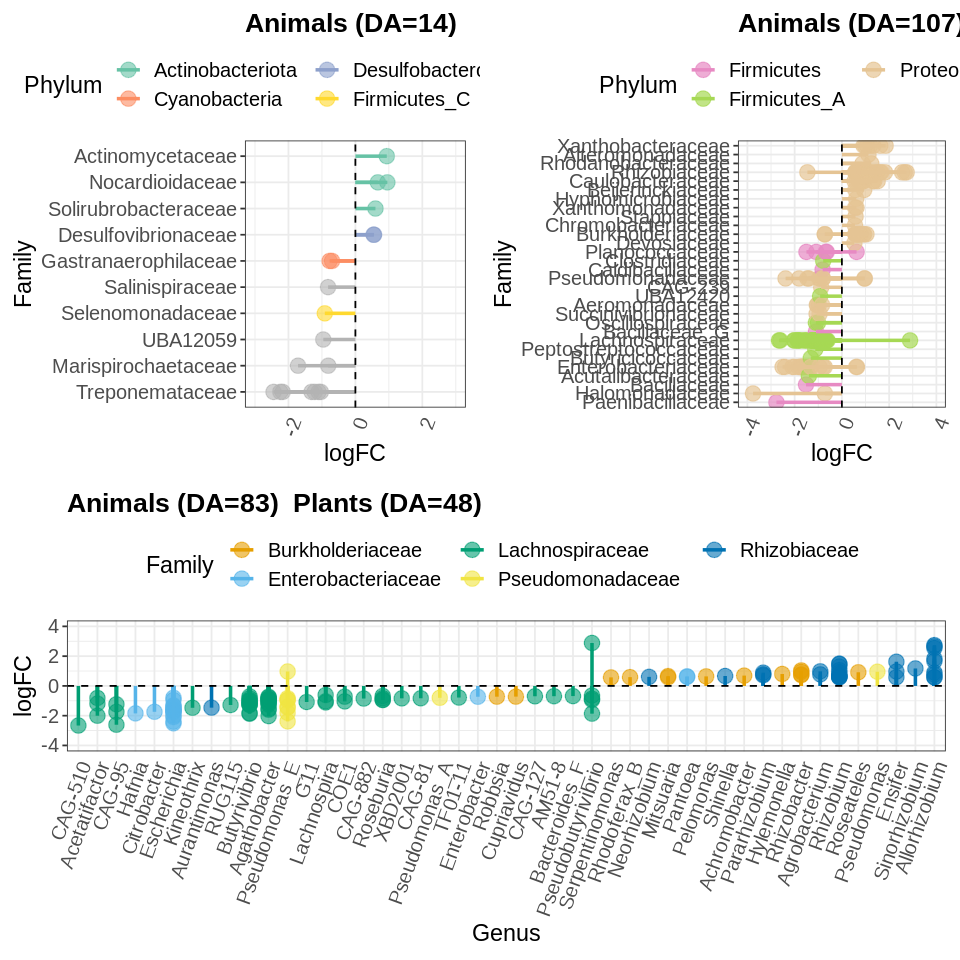

In [299]:
grid.arrange(grobs = grobs.plots , layout_matrix = lay )

##### E. Plot hetamaps with DA flagellins

In [302]:
#Subset the phyloseq with the DA flagellins in biome_1
DAs.host=rownames(sigtab.host)
psDA_host = prune_taxa(DAs.host,nonrare.psAll.filt)
psDA_host

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 203 taxa and 352 samples ]
sample_data() Sample Data:       [ 352 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 203 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 203 tips and 202 internal nodes ]

In [303]:
annotations.host = annotationsForHeatmap(psDA_host)

ERROR: Error in data.frame(sample = ps_obj@sam_data$Sample, biome1 = ps_obj@sam_data$biome_1, : arguments imply differing number of rows: 352, 0


In [301]:
head(annotations.host)

ERROR: Error in head(annotations.host): object 'annotations.host' not found


In [77]:
matrix.host = createMatrixForHetmap(psDA_host)

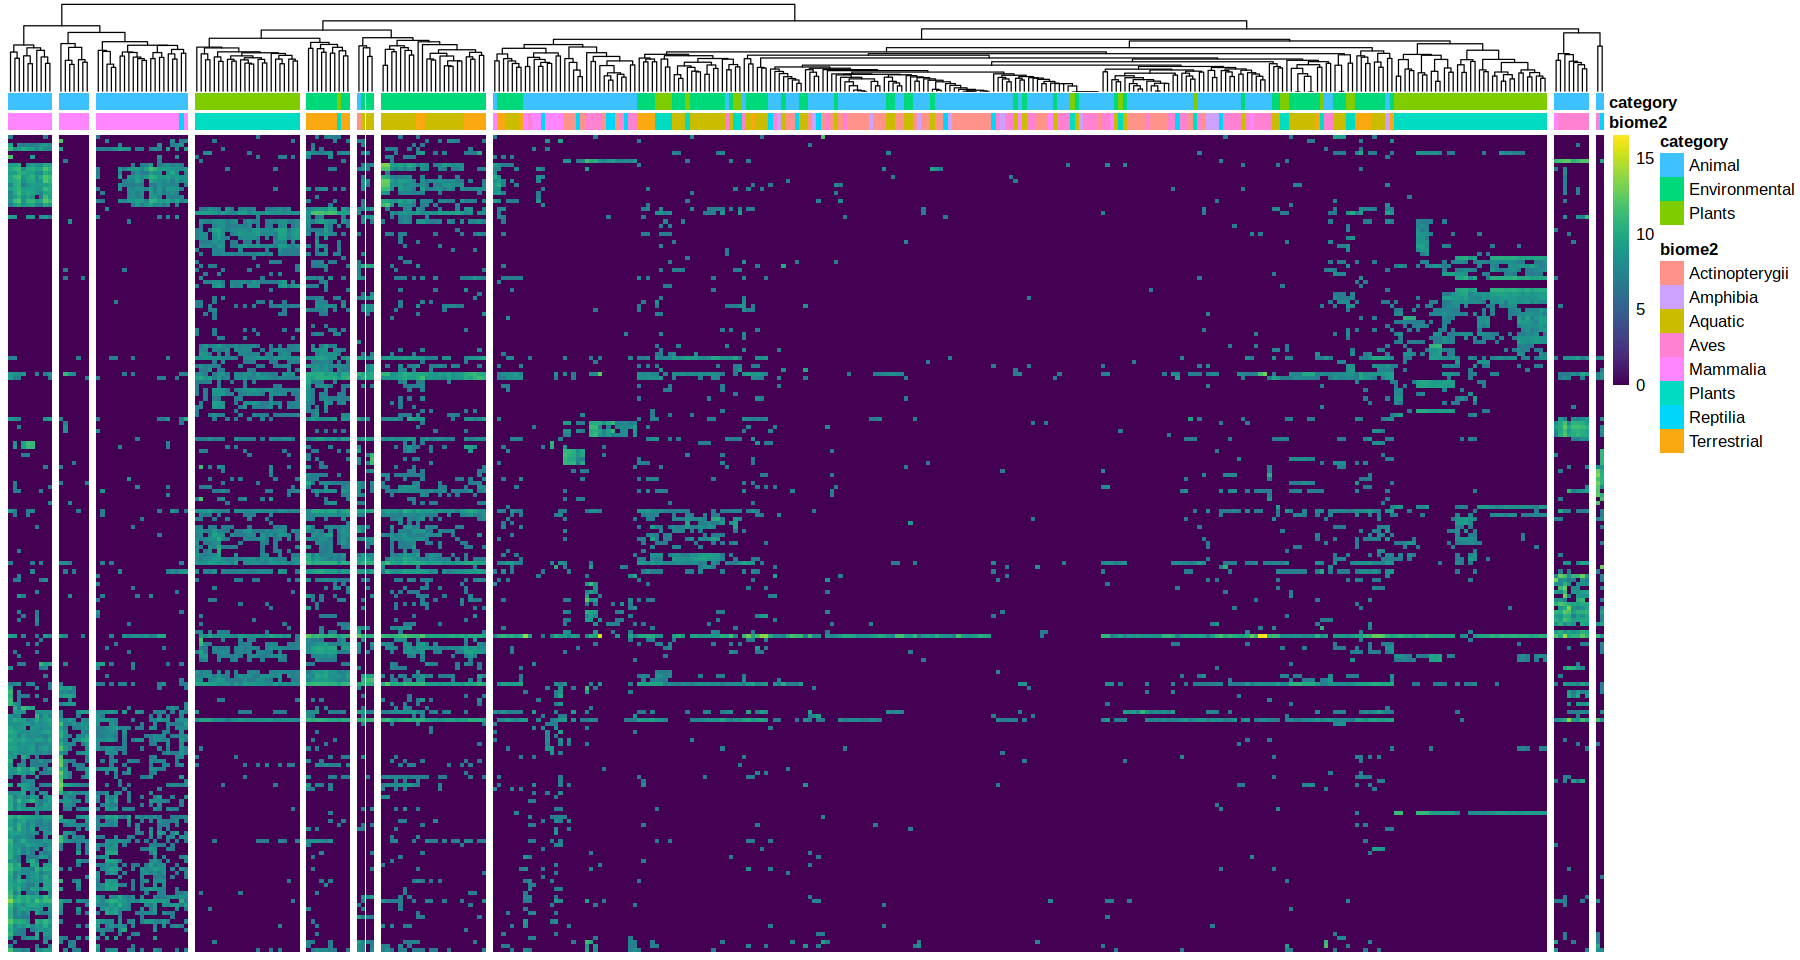

In [78]:
options(repr.plot.width=15,repr.plot.height=8)
pheatmap(matrix.host, cutree_cols = 10,
         cluster_cols=TRUE,
         cluster_rows=FALSE,
         show_rownames=F,
         show_colnames=F,
         labels_row=annotations.biome1$annotation.row$Phylum,
         annotation_col=select(annotations.biome1$annotation.col,c(biome2,category)),
          color = viridis(n = 256, alpha = 1, 
                                   begin = 0, end = 1, option = "viridis")
)

In [79]:
tmp.host = ps_filter(subset.host.nonrare.filt,mammals != "Mammalia")

In [80]:
#Perform differentially abundance analysis
#tmp.host = ps_filter(subset.host.nonrare.filt,mammals != "Mammalia")
edger.host.nomammals = runEdgeR(tmp.host,groupToCompare="category")

[1] "Animal" "Plants"
[1] "BH"
[1] "exact"


In [81]:
#Table with DA flagellins
sigtab.host.nomammals = edger.host.nomammals$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.host.nomammals = edger.host.nomammals$sigtabgen

In [82]:
nrow(sigtab.host.nomammals)

[1] 105

In [83]:
sigtab.host.nomammals = sigtab.host.nomammals %>%
    mutate(EnrichedIn=ifelse(logFC>0,"Plants","Animals"))
head(sigtab.host.nomammals)

Domain      Phylum            Class                 
SFH83235.1 d__Bacteria p__Firmicutes_A   c__Clostridia         
EHS52757.1 d__Bacteria p__Proteobacteria c__Alphaproteobacteria
EHS53753.1 d__Bacteria p__Proteobacteria c__Alphaproteobacteria
EHS53752.1 d__Bacteria p__Proteobacteria c__Alphaproteobacteria
PYB77514.1 d__Bacteria p__Proteobacteria c__Alphaproteobacteria
KPF42046.1 d__Bacteria p__Proteobacteria c__Alphaproteobacteria
           Order             Family             Genus                
SFH83235.1 o__Lachnospirales f__Lachnospiraceae g__Pseudobutyrivibrio
EHS52757.1 o__Rhizobiales    f__Rhizobiaceae    g__Allorhizobium     
EHS53753.1 o__Rhizobiales    f__Rhizobiaceae    g__Allorhizobium     
EHS53752.1 o__Rhizobiales    f__Rhizobiaceae    g__Allorhizobium     
PYB77514.1 o__Rhizobiales    f__Rhizobiaceae    g__Allorhizobium     
KPF42046.1 o__Rhizobiales    f__Rhizobiaceae    g__Allorhizobium     
           Species                           logFC    logCPM   PValue      
SFH83235.1 s__Pseudobutyrivibrio sp900113655 2.891041 11.28574 4.418991e-39
EHS52757.1 s__Allorhizobium sp000247475      2.735384 11.21612 1.232855e-33
EHS53753.1 s__Allorhizobium sp000247475      2.665462 11.20550 1.571604e-32
EHS53752.1 s__Allorhizobium sp000247475      2.546027 11.10798 4.263784e-31
PYB77514.1 s__Allorhizobium wuzhouense       1.824623 10.80193 4.233253e-22
KPF42046.1 s__Allorhizobium sp001296045      1.657901 10.75909 1.180100e-20
           FDR          EnrichedIn
SFH83235.1 8.572843e-36 Plants    
EHS52757.1 1.195870e-30 Plants    
EHS53753.1 1.016304e-29 Plants    
EHS53752.1 2.067935e-28 Plants    
PYB77514.1 1.642502e-19 Plants    
KPF42046.1 3.815656e-18 Plants

In [84]:
count(sigtab.host.nomammals,EnrichedIn)

EnrichedIn n 
1 Animals    42
2 Plants     63

Warning message:
“Duplicated aesthetics after name standardisation: yend”


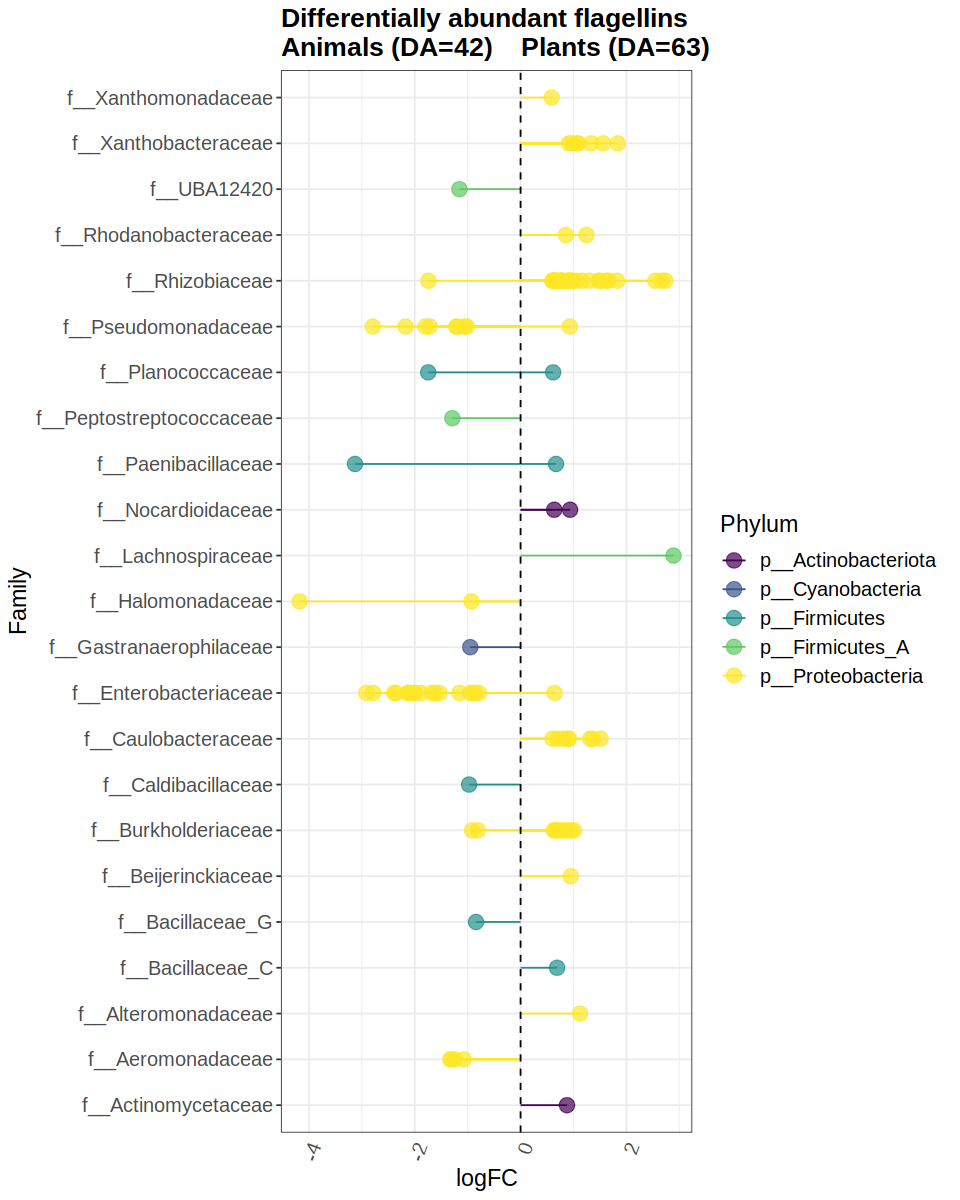

In [85]:
options(repr.plot.width=8,repr.plot.height=10)

#png(file="plants.vs.animals.enriched.png",width=12,height=6)
ggplot(sigtab.host.nomammals, aes(y = Family, x = logFC, color = Phylum)) + geom_point(size=4,alpha=0.7) + 
theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Family,yend=Family),size=0.5)+
  geom_vline(xintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14)) +
  ggtitle("Differentially abundant flagellins
Animals (DA=42)    Plants (DA=63)")
#dev.off() 

## 5. Mammals vs. non-mammals

In [307]:
ps.verts=subset_samples(nonrare.psAll.filt,category=="Animal")
ps.verts

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1971 taxa and 178 samples ]
sample_data() Sample Data:       [ 178 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1971 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1971 tips and 1970 internal nodes ]

In [308]:
#Perform differentially abundance analysis
edger.verts = runEdgeR(ps.verts,groupToCompare="mammals")

In [309]:
#Table with DA flagellins
sigtab.verts = edger.verts$sigtab.final

#Table with DA flagellins - sorted
sigtabgen.verts = edger.verts$sigtabgen

In [310]:
sigtab.verts = sigtab.verts %>%
    mutate(EnrichedIn=ifelse(logFC>0,"Non-mammals","Mammalia"))

In [311]:
head(sigtab.verts)

Domain      Phylum           Class           Order            
RHP37040.1     d__Bacteria p__Firmicutes_A  c__Clostridia   o__Lachnospirales
SJZ39514.1     d__Bacteria p__Spirochaetota c__Spirochaetia o__Treponematales
CDA67770.1     d__Bacteria p__Firmicutes_A  c__Clostridia   o__Lachnospirales
WP_022931566.1 d__Bacteria p__Spirochaetota c__Spirochaetia o__Treponematales
CDD46301.1     d__Bacteria p__Firmicutes_A  c__Clostridia   o__Lachnospirales
EIC00583.1     d__Bacteria p__Spirochaetota c__Spirochaetia o__Treponematales
               Family             Genus           
RHP37040.1     f__Lachnospiraceae g__Acetatifactor
SJZ39514.1     f__Treponemataceae g__Treponema_D  
CDA67770.1     f__Lachnospiraceae g__CAG-510      
WP_022931566.1 f__Treponemataceae g__Treponema_D  
CDD46301.1     f__Lachnospiraceae g__CAG-95       
EIC00583.1     f__Treponemataceae g__Treponema_D  
               Species                       logFC     logCPM   PValue      
RHP37040.1     s__Acetatifactor sp900066565  -5.406454 13.26222 1.504151e-72
SJZ39514.1     s__Treponema_D porcinum       -3.959653 11.79228 1.437939e-61
CDA67770.1     s__CAG-510 sp000434615        -4.287332 11.94802 5.126482e-59
WP_022931566.1 s__Treponema_D bryantii_C     -3.702149 11.62705 4.534968e-57
CDD46301.1     s__CAG-95 sp000436115         -4.117898 11.90718 4.177139e-55
EIC00583.1     s__Treponema_D saccharophilum -3.482338 11.59900 1.287153e-50
               FDR          EnrichedIn
RHP37040.1     2.796217e-69 Mammalia  
SJZ39514.1     1.336564e-58 Mammalia  
CDA67770.1     3.176710e-56 Mammalia  
WP_022931566.1 2.107626e-54 Mammalia  
CDD46301.1     1.553060e-52 Mammalia  
EIC00583.1     3.988028e-48 Mammalia

#### Export list of Differentially Abundant flagellins

In [91]:
DA.mammals = rownames_to_column(sigtab.verts,var = "Accession")
write_tsv(DA.mammals,"subsampled_opt1/DA.mammal_subsampled1.tsv")

#### Plots

##### A. Phylum-level

In [312]:
count(sigtab.verts,logFC<0)

logFC < 0 n  
1 FALSE      29
2  TRUE     169

In [159]:
### summarize flagellins from shared phyla between plants and animals

In [313]:
count(sigtab.verts,EnrichedIn)

EnrichedIn  n  
1 Mammalia    169
2 Non-mammals  29

In [360]:
listEnrichedBiomes3 = list(mammals=filter(sigtab.verts,EnrichedIn=="Mammalia"),animals=filter(sigtab.verts,EnrichedIn=="Non-mammals"))

In [361]:
taxSummary3 = lapply(listEnrichedBiomes3,getTaxSummary)

In [362]:
taxSummBiomes3 = bind_rows(taxSummary3)
taxSummBiomes3

EnrichedIn  totalEnriched NoPhyla NoClass NoOrder NoFamily NoGenus NoSpecies
1 Mammalia    169           9       14      28      37       77      117      
2 Non-mammals  29           3        4       7       9       12       20

In [305]:
phylum.colors = phylum.colors %>%
rbind(c("Patescibacteria","#CC79A7"))

In [445]:
write_tsv(phylum.colors,"../../FlagellinDiversity/Figures/phylum.colors.tsv")

In [315]:
sigtab.verts = sigtab.verts %>%
                mutate(Phylum=str_remove_all(Phylum,"p__"))%>%
                mutate(Family=str_remove_all(Family,"f__"))%>%
                mutate(Genus=str_remove_all(Genus,"g__"))%>%
                mutate(Species=str_remove_all(Species,"s__"))

In [429]:
#options(repr.plot.width=8,repr.plot.height=10)

#png(file="plants.vs.animals.enriched.png",width=12,height=6)
fig11.a = ggplot(sigtab.verts, aes(y = reorder(Family,logFC), x = logFC, color = Phylum)) + geom_point(size=4,alpha=0.7) + 
theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Family,yend=Family),size=1)+
  geom_vline(xintercept = 0, size=0.5, linetype="dashed") +
  scale_color_manual(values = phylum.colors$color,
                    limits = phylum.colors$Phylum)+
  theme(axis.text = element_text(size=12),
        axis.ticks.x = element_blank(),
        plot.title = element_text(size=16, face="bold"),
       legend.text = element_text(size=12),
       legend.title = element_text(size=14),
       axis.title = element_text(size=14),
       legend.position = "top",
        legend.justification="left",
       plot.tag = element_text(size=20,face="bold")) +
  ggtitle("Mammals (DA=169)    Non-mammals (DA=29)")+
xlim(c(-5,5))+
guides(color = guide_legend(nrow=3,col=3) )+
ylab("logFC")+
labs(tag="A")
#dev.off() 

Warning message:
“Duplicated aesthetics after name standardisation: yend”


##### A. Family-level

Warning message:
“Duplicated aesthetics after name standardisation: xend”
Warning message:
“Duplicated aesthetics after name standardisation: xend”


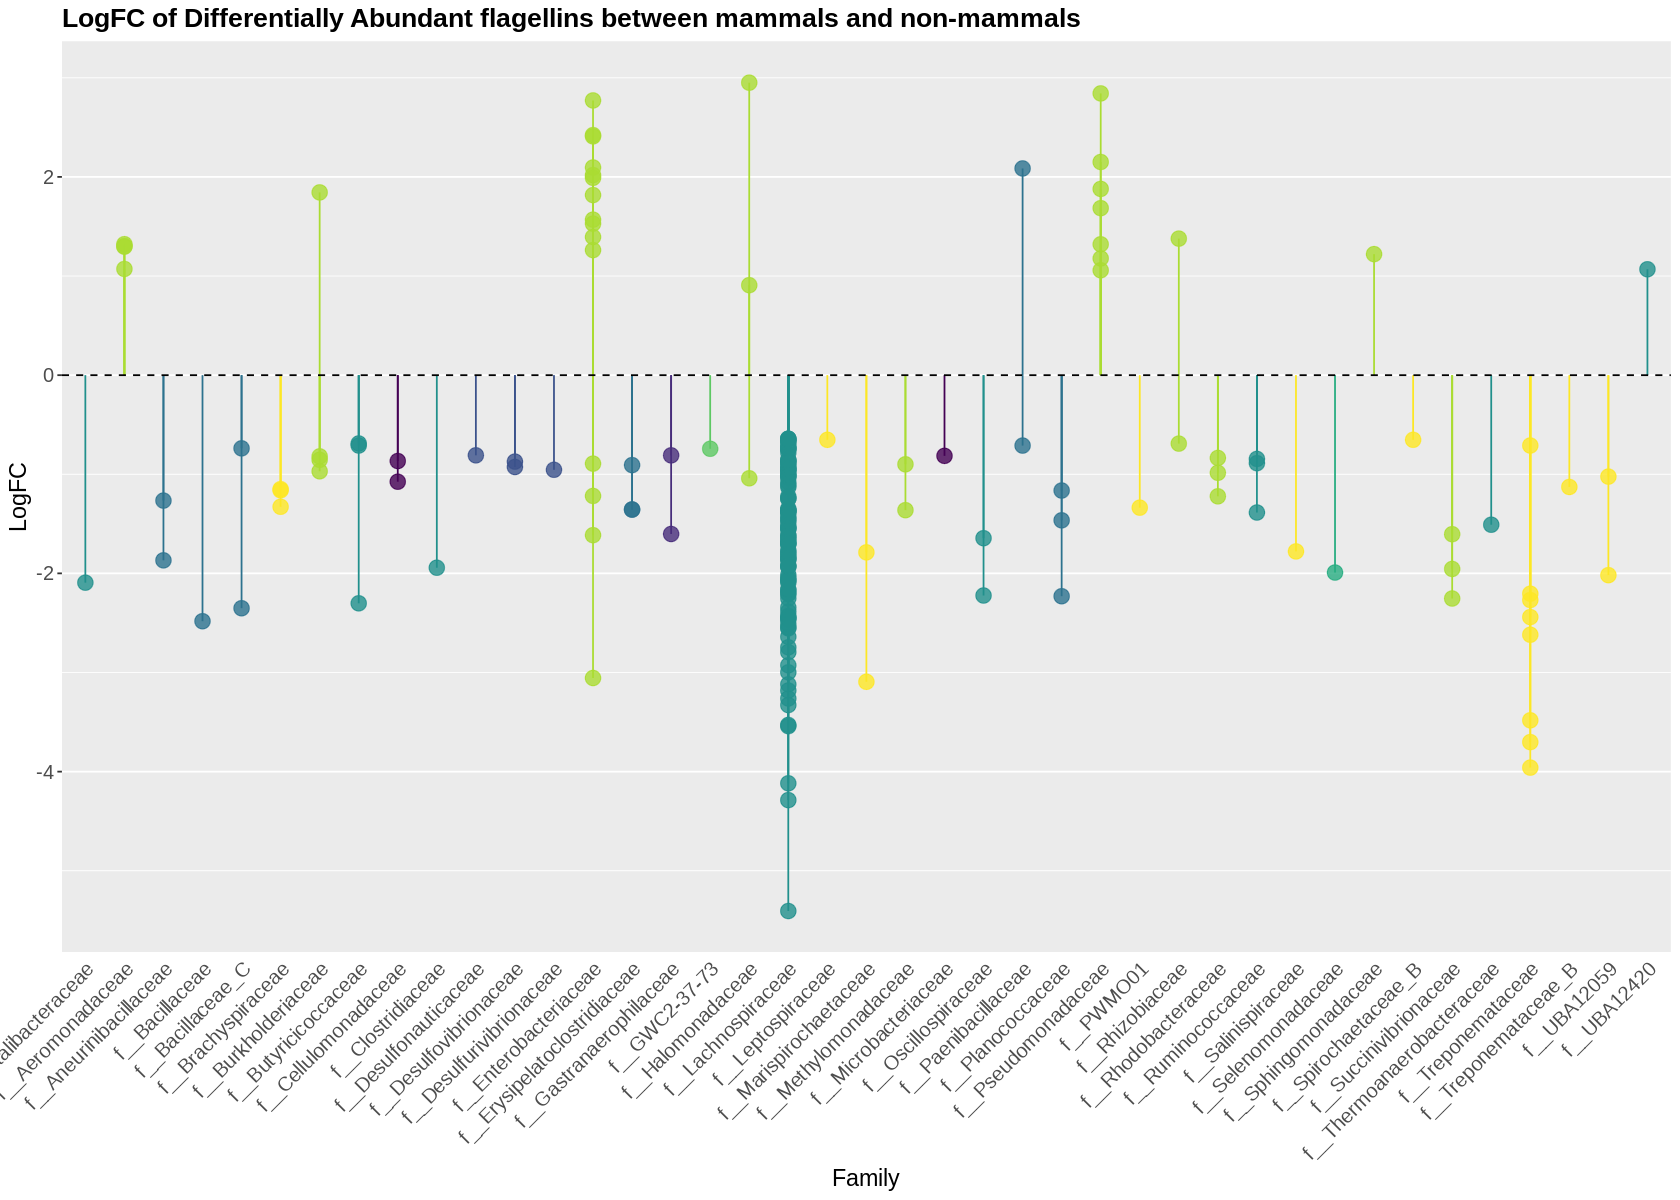

In [409]:
ggplot(sigtabgen.verts, aes(x = Family, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
  geom_segment(aes(y=0,yend=logFC,xend=Family,xend=Family),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none",
       legend.justification="left") +
  ggtitle("LogFC of Differentially Abundant flagellins between mammals and non-mammals")+
  labs(x = "Family", y = "LogFC")

##### A. Species-level: Only Lachnospiraceae

In [326]:
fam.colors

Family             color  
1 Burkholderiaceae   #E69F00
2 Enterobacteriaceae #56B4E9
3 Lachnospiraceae    #009E73
4 Pseudomonadaceae   #F0E442
5 Rhizobiaceae       #0072B2

In [439]:
nrow(lachno.animals)

[1] 98

In [441]:
#options(repr.plot.width=15,repr.plot.height=6)
lachno.animals = filter(sigtabgen.verts,Family=="f__Lachnospiraceae") %>% mutate(Genus = str_remove_all(Genus,"g__"))
fig11.b = ggplot(lachno.animals, aes(y = reorder(Genus,logFC), x = logFC, color = Family)) +geom_point(size=4, alpha=0.6) + 
theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Genus,yend=Genus),size=1)+
  geom_vline(xintercept = 0, size=0.5, linetype="dashed") +
  scale_color_manual(values = "#009E73" )+
  theme(axis.text.x = element_text(size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none",
       plot.tag = element_text(size=20,face="bold")) +
       labs(x = "Family", y = "LogFC")+
       labs(tag = "B")+
        xlim(c(-5,5))

Warning message:
“Duplicated aesthetics after name standardisation: yend”


In [364]:
library(reshape2)

In [379]:
#taxSummBiomes3
meltTaxBiomes.mamm = melt(taxSummBiomes3) %>%
    mutate(variable = str_remove_all(variable,"No"))
meltTaxBiomes.mamm

Using EnrichedIn as id variables



EnrichedIn  variable      value
1  Mammalia    totalEnriched 169  
2  Non-mammals totalEnriched  29  
3  Mammalia    Phyla           9  
4  Non-mammals Phyla           3  
5  Mammalia    Class          14  
6  Non-mammals Class           4  
7  Mammalia    Order          28  
8  Non-mammals Order           7  
9  Mammalia    Family         37  
10 Non-mammals Family          9  
11 Mammalia    Genus          77  
12 Non-mammals Genus          12  
13 Mammalia    Species       117  
14 Non-mammals Species        20

In [380]:
meltTaxBiomes.mamm$variable <- factor(meltTaxBiomes.mamm$variable, levels = c('totalEnriched', 'Phyla', 'Class', 'Order', 'Family', 'Genus', 'Species'))


In [370]:
cols.mamm = data.frame(EnrichedIn = c("Mammalia","Non-mammals"),
color = c("#7E6148FF","#F0941F"))

In [371]:
cols.mamm

EnrichedIn  color    
1 Mammalia    #7E6148FF
2 Non-mammals #F0941F

In [415]:
# Plotting with ggplot2
#tax.biome1 = 
fig11.c = ggplot(meltTaxBiomes.mamm, aes(x = variable, y = value, fill = EnrichedIn)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.8,alpha=0.6) +  # Use position_dodge() for side-by-side bars
scale_fill_discrete(name="Enriched in",labels=c("Mammals","Non-mammals"))+
scale_fill_manual(values = cols.mamm$color,
                 limits = cols.mamm$EnrichedIn)+
  labs(x = "Taxonomic Rank",
       y = "Count") +  # Adjusted for clarity
  theme_minimal() +
  theme(text = element_text(size = 14),
        axis.text.x = element_text(angle = 0,size=14),
        legend.position = "top",
        legend.justification="left",
        plot.title = element_text(hjust = 0.5),
        plot.tag = element_text(size=20,face="bold"))+
  geom_text(aes(label = value), vjust = -0.3, position = position_dodge(width = 0.7), size = 5, check_overlap = TRUE) +
  guides(fill = guide_legend(title = "EnrichedIn"))+
  labs(tag = "C")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


In [442]:
lay.m <- rbind(c(1,2),
               c(1,2),
               c(1,3))
grobs.plots.m = list(fig11.a,fig11.b,fig11.c)

In [443]:
#file("/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/FlagellinDiversity/Figures/Figure1.pdf")
pdf(file.path(figures_path,"Figure11.pdf"), width = 14, height = 14)
grid.arrange(grobs = grobs.plots.m , layout_matrix = lay.m )
dev.off()

Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”


png 
  2

In [438]:
#file("/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/FlagellinDiversity/Figures/Figure1.pdf")
png(file.path(figures_path,"Figure11.png"),width=1024, height=860)
grid.arrange(grobs = grobs.plots.m , layout_matrix = lay.m )
dev.off()

Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”


png 
  2

Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”


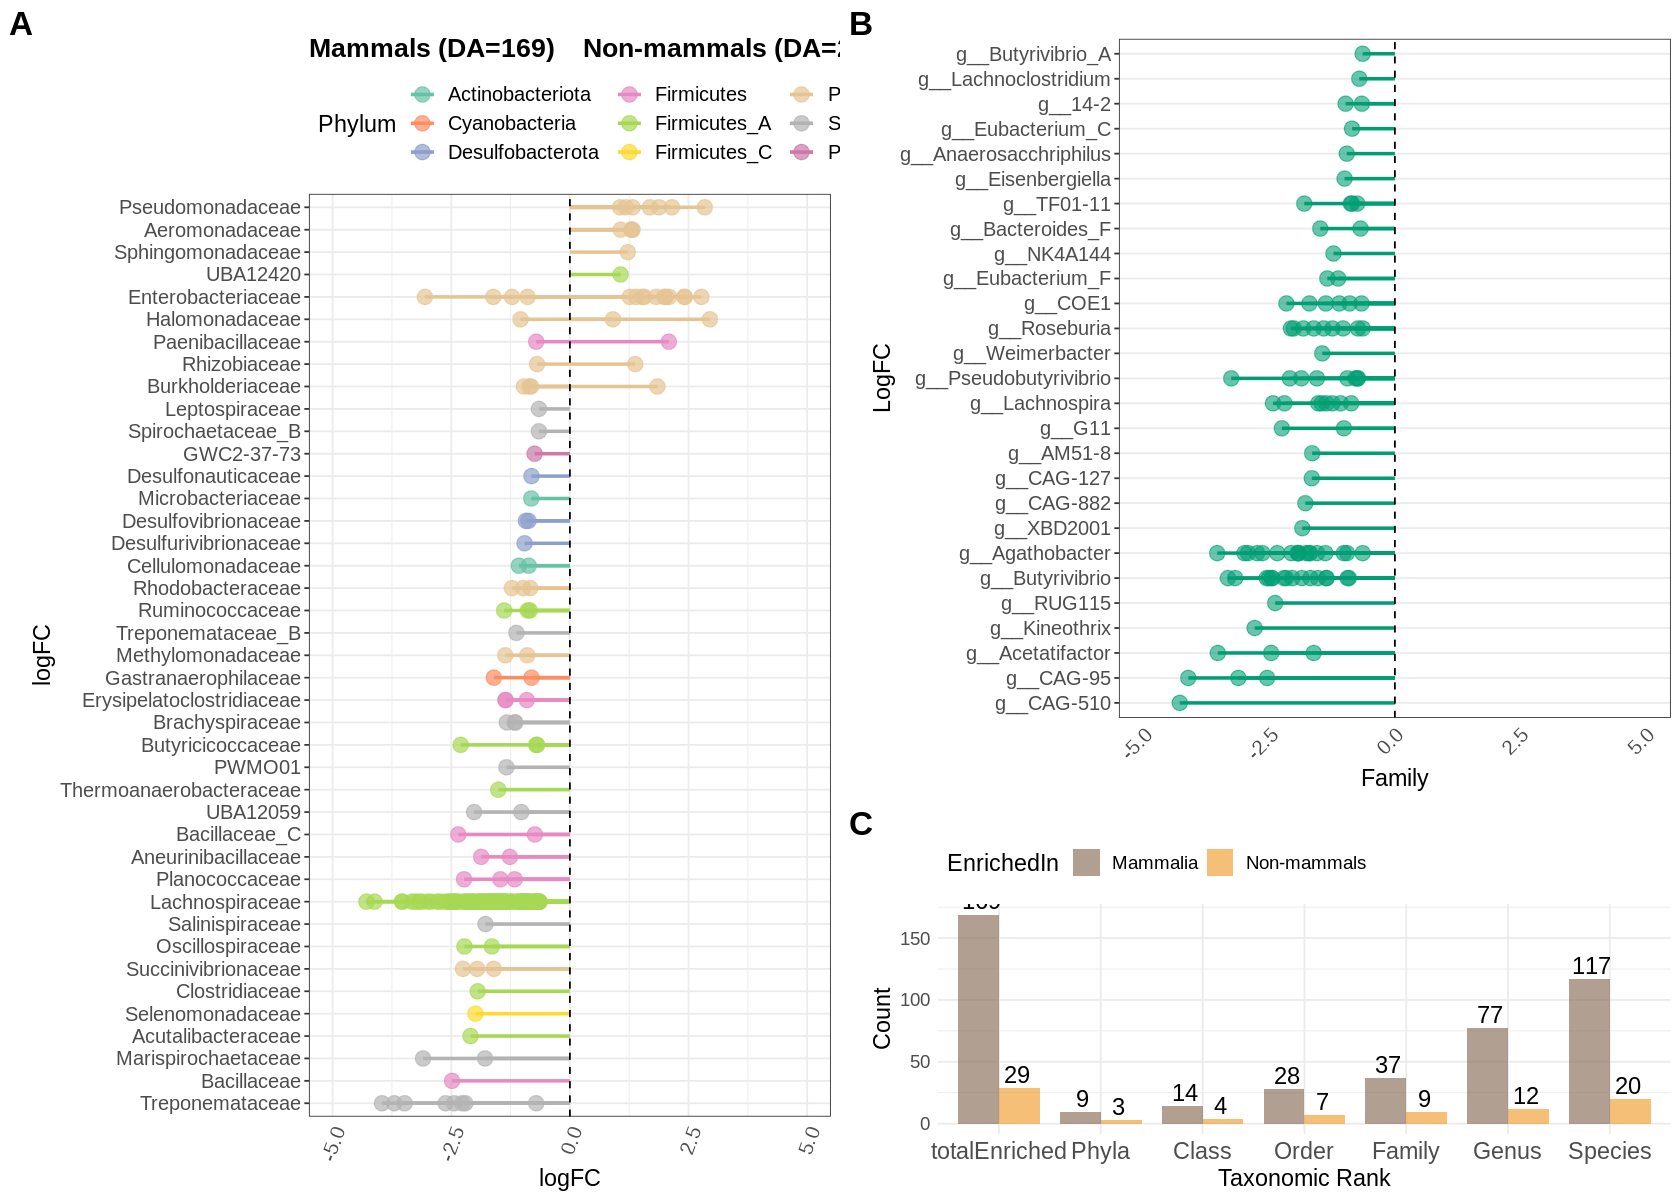

In [418]:
options(repr.plot.width=14)
grid.arrange(grobs = grobs.plots.m , layout_matrix = lay.m )

## 5. Mammals vs. Aves

In [453]:
combinations = list(c("Mammalia","Aves"),
c("Mammalia","Actinopterygii"),
c("Mammalia","Reptilia"),
c("Mammalia","Amphibia"),
c("Amphibia","Reptilia"),
c("Amphibia","Actinopterygii"),
c("Amphibia","Aves"),
c("Reptilia","Actinopterygii"),
c("Aves","Actinopterygii"),
c("Aves","Reptilia"))

In [518]:
ps.verts.tmp=subset_samples(nonrare.psAll.filt,biome_2%in%c("Aves","Reptilia"))

#Perform differentially abundance analysis
edger.tmp = runEdgeR(ps.verts.tmp,groupToCompare="biome_2")

#Table with DA flagellins - sorted
sigtabgen.tmp = edger.tmp$sigtabgen

In [519]:
#to create
sigtabgen.ave.rept = sigtabgen.tmp

In [521]:
listEnrichedBiomes.withinAnimals = list(sigtabgen.mammal.aves,
                          sigtabgen.fish.mammals,
                          sigtabgen.rept.mamm,
                          sigtabgen.amph.mamm,
                          sigtabgen.amph.ave,
                          sigtabgen.amph.fish,
                          sigtabgen.amph.rept,
                          sigtabgen.rept.fish,
                          sigtabgen.ave.fish,
                          sigtabgen.ave.rept)

In [557]:
taxSummarywithinAnimals = lapply(listEnrichedBiomes.withinAnimals,getTaxSummary_pairwiseComparisons)

In [558]:
taxSummAnimals = bind_rows(taxSummarywithinAnimals)
taxSummAnimals

EnrichedIn     totalEnriched NoPhyla NoClass NoOrder NoFamily NoGenus
1  Aves            46           4        5      10      12       22     
2  Mammalia       132           7       10      20      28       58     
3  Actinopterygii   7           2        2       3       3        3     
4  Mammalia       141           8       12      24      31       63     
5  Mammalia        32           3        3       5       5       14     
6  Reptilia        27           2        3       5       7       16     
7  Mammalia         4           2        2       2       2        2     
8  NA               0           0        0       0       0        0     
9  NA               0           0        0       0       0        0     
10 NA               0           0        0       0       0        0     
11 NA               0           0        0       0       0        0     
12 NA               0           0        0       0       0        0     
13 NA               0           0        0       0       0        0     
14 NA               0           0        0       0       0        0     
15 Reptilia        24           4        5       7       8       17     
16 NA               0           0        0       0       0        0     
17 Actinopterygii   7           2        3       3       3        3     
18 Aves            55           4        5      13      15       28     
19 Aves             3           1        1       2       2        2     
20 Reptilia        14           2        2       4       6        9     
   NoSpecies comparison               
1  30        Aves _ Mammalia          
2  91        Aves _ Mammalia          
3   5        Actinopterygii _ Mammalia
4  97        Actinopterygii _ Mammalia
5  25        Mammalia _ Reptilia      
6  23        Mammalia _ Reptilia      
7   4        Mammalia _ NA            
8   0        Mammalia _ NA            
9   0        NA _ NA                  
10  0        NA _ NA                  
11  0        NA _ NA                  
12  0        NA _ NA                  
13  0        NA _ NA                  
14  0        NA _ NA                  
15 22        Reptilia _ NA            
16  0        Reptilia _ NA            
17  5        Actinopterygii _ Aves    
18 38        Actinopterygii _ Aves    
19  3        Aves _ Reptilia          
20 11        Aves _ Reptilia

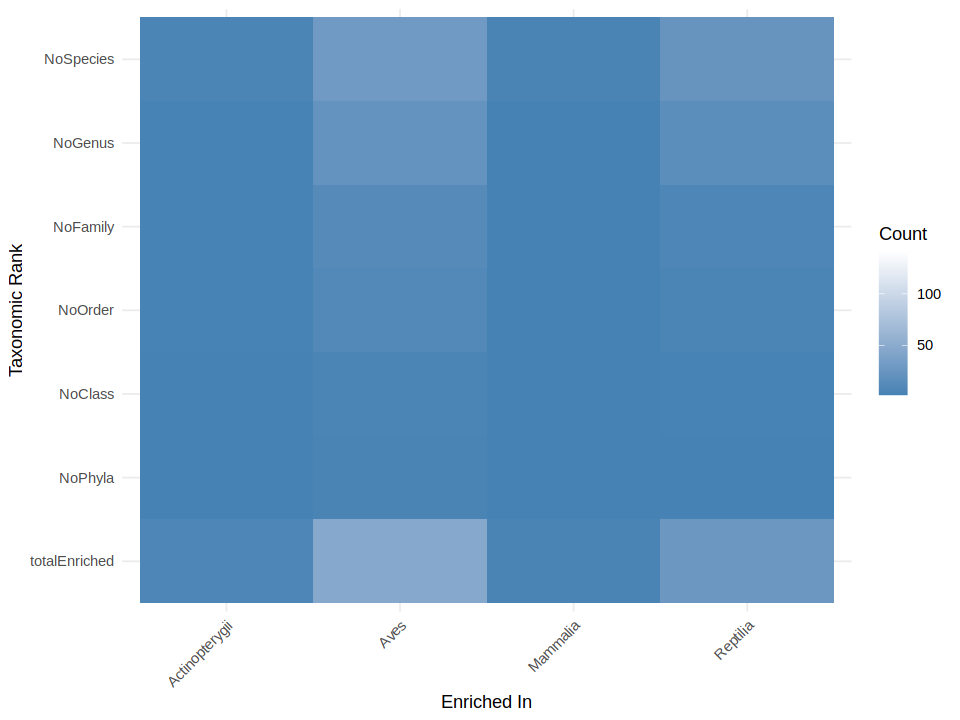

In [565]:
options(repr.plot.width=8)
# Load necessary libraries
library(ggplot2)
library(reshape2) # For melting data frames

# Assuming 'data' is your dataframe
# data <- read.csv("your_data.csv") # If your data is in a CSV file

# Your data might look something like this:
data <- data.frame(
  EnrichedIn = c("Aves", "Mammalia", "Actinopterygii", "Mammalia", "Mammalia", "Reptilia", "Mammalia"),
  totalEnriched = c(46, 132, 7, 141, 32, 27, 4),
  NoPhyla = c(4, 7, 2, 8, 3, 2, 2),
  NoClass = c(5, 10, 2, 12, 3, 3, 2),
  NoOrder = c(10, 20, 3, 24, 5, 5, 2),
  NoFamily = c(12, 28, 3, 31, 5, 7, 2),
  NoGenus = c(22, 58, 3, 63, 14, 16, 2),
    NoSpecies = c(30, 91, 5, 97, 25, 23, 4),
    Comparison = c("Aves_Mammalia", "Aves_Mammalia", "Actinopterygii_Mammalia",
"Actinopterygii_Mammalia", "Mammalia_Reptilia", "Mammalia_Reptilia", "Mammalia_Amphibia")
)

data_melted <- melt(data, id.vars = c("EnrichedIn", "Comparison"))

ggplot(data_melted, aes(x = EnrichedIn, y = variable, fill = value)) +
geom_tile() + # This creates the heatmap tiles
scale_fill_gradient(high = "white", low = "steelblue") + # Color gradient for the fill
theme_minimal() + # Minimal theme for a cleaner look
labs(x = "Enriched In", y = "Taxonomic Rank", fill = "Count") + # Labels for axes and legend
theme(axis.text.x = element_text(angle = 45, hjust = 1)) # Rotate x labels for better readability

In [482]:
# Loop through each combination
result_list = list()

for (i in combinations) {
  # Create the filter string with quotes and a comma
  filter_string <- paste0("'", paste(i, collapse = "', '"), "'")
     # Create a new list for each iteration to store tmp.ps
  tmp_list <- list()
  
  # Create the subset_samples command with the current combination
  subset_command <- paste("tmp.ps = subset_samples(nonrare.psAll.filt, biome_2 %in% c(", filter_string, "))")
  print(subset_command)
  # Execute the subset_samples command
  eval(parse(text = subset_command))
  
  # Print or use tmp.ps as needed

  # You may consider storing tmp.ps in a list or another data structure if needed
#    listAllsubsets = c(listAllsubsets,list(tmp.ps))
    
 # Append tmp.ps to the tmp_list
    tmp_list$tmp.ps <- tmp.ps
  
  # Append the tmp_list to the result_list
  result_list <- c(result_list, list(tmp_list))

    return(tmp_list)
}

[1] "tmp.ps = subset_samples(nonrare.psAll.filt, biome_2 %in% c( 'Mammalia', 'Aves' ))"


$tmp.ps
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1971 taxa and 102 samples ]
sample_data() Sample Data:       [ 102 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1971 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1971 tips and 1970 internal nodes ]


In [397]:
nrow(filter(sigtabgen.mammal.aves,logFC>0))
nrow(filter(sigtabgen.fish.mammals,logFC>0)
sigtabgen.rept.mamm,
                          sigtabgen.amph.mamm,
                          sigtabgen.amph.ave,
                          sigtabgen.amph.fish,
                          sigtabgen.amph.rept,
                          sigtabgen.rept.fish,
                          sigtabgen.ave.fish,
                          sigtabgen.ave.rept)

[1] 132

Warning message:
“Duplicated aesthetics after name standardisation: xend”


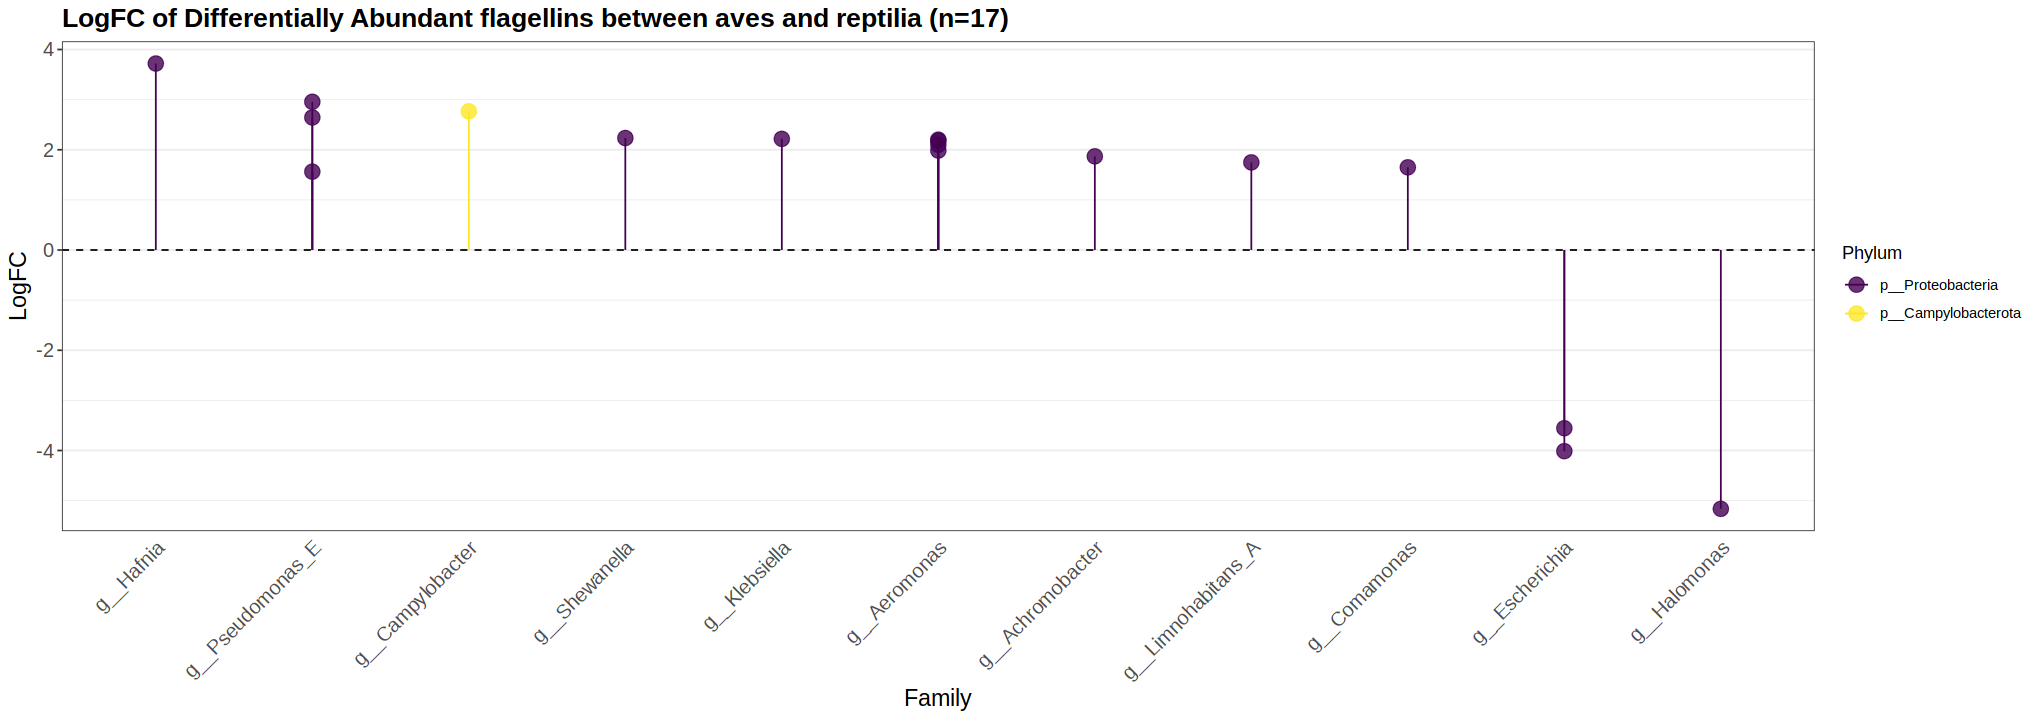

In [253]:
options(repr.plot.width=17,repr.plot.height=6)
#lachno.animals = filter(sigtabgen.verts,Family=="f__Lachnospiraceae")
tmp.plot = sigtabgen.ave.rept
ggplot(tmp.plot, aes(x = Genus, y = logFC, color = Phylum)) +geom_point(size=4, alpha=0.8) + 
theme_bw()+
  geom_segment(aes(y=0,yend=logFC,xend=Genus,xend=Genus),size=0.5)+
  geom_hline(yintercept = 0, size=0.5, linetype="dashed") +
  scale_color_viridis_d()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
       plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="right") +
  ggtitle("LogFC of Differentially Abundant flagellins between aves and reptilia (n=17)")+
  labs(x = "Family", y = "LogFC")

In [89]:
sigtab.verts = sigtab.verts %>%
    mutate(EnrichedIn=ifelse(logFC>0,"Non-mammals","Mammalia"))

In [339]:
ps.verts.tmp=subset_samples(nonrare.psAll.filt,biome_2%in%c("Aves","Mammalia"))

In [341]:
test.edger = runEdgeR(ps.verts.tmp,groupToCompare="biome_2")$sigtab.final